In [ ]:
"""
===================================================================================
SPRINT 3: ADVANCED DROPOUT INSIGHTS & CROSS-DOMAIN ANALYSIS
===================================================================================
Project: Multi-dimensional Education Dropout Analysis
Purpose: Integrate dropout data with socio-economic, health, nutrition, and
         security indicators to uncover root causes
Author: Data Science Team
Date: October 2025
===================================================================================
"""

print("="*80)
print("SPRINT 3: CROSS-DOMAIN DROPOUT ANALYSIS")
print("="*80)

# Standard libraries
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
import os
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical and ML libraries
from scipy import stats
from scipy.stats import chi2_contingency, pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ All libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

SPRINT 3: CROSS-DOMAIN DROPOUT ANALYSIS
✅ All libraries imported successfully
📅 Analysis Date: 2025-10-31 15:35:42


In [ ]:
# ===================================================================================
# SECTION 2: MOUNT GOOGLE DRIVE & DISCOVER DATASETS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 2: CONNECTING TO GOOGLE DRIVE & DISCOVERING DATASETS")
print("="*80)

# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("✅ Google Drive mounted successfully!")
    BASE_PATH = '/content/drive/MyDrive/Education_Data_Analysis/'
except:
    print("⚠️ Not running in Google Colab, using local path")
    BASE_PATH = './'

print(f"\n📁 Base path: {BASE_PATH}")

# List all files
if os.path.exists(BASE_PATH):
    all_files = os.listdir(BASE_PATH)
    print(f"\n✅ Found {len(all_files)} files/folders:")

    # Categorize files
    excel_files = [f for f in all_files if f.endswith(('.xlsx', '.xls'))]
    csv_files = [f for f in all_files if f.endswith('.csv')]

    print(f"\n📊 Excel Files ({len(excel_files)}):")
    for f in excel_files:
        print(f"   - {f}")

    print(f"\n📄 CSV Files ({len(csv_files)}):")
    for f in csv_files:
        print(f"   - {f}")
else:
    print(f"❌ Directory not found: {BASE_PATH}")
    raise FileNotFoundError(f"Please update BASE_PATH")

print("\n✅ Section 2 Complete - Files discovered")


SECTION 2: CONNECTING TO GOOGLE DRIVE & DISCOVERING DATASETS
Mounted at /content/drive
✅ Google Drive mounted successfully!

📁 Base path: /content/drive/MyDrive/Education_Data_Analysis/

✅ Found 16 files/folders:

📊 Excel Files (2):
   - Diccionario_0.xlsx
   - Dataset Undergraduate Applicants 2025 I.xlsx

📄 CSV Files (3):
   - Educacion_Secundaria.csv
   - Educacion_Primaria.csv
   - ubigeo_ccpp.csv

✅ Section 2 Complete - Files discovered


In [ ]:
# ===================================================================================
# SECTION 3: LOAD ALL 4 DATASETS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 3: LOADING ALL DATASETS")
print("="*80)

# Dictionary to store datasets
datasets = {}

# 3.1 Load Dataset 1: Base Applicants/Dropout Data
print("\n📂 [1/4] Loading Base Education Dataset...")
try:
    # Try enriched dataset first, then original
    if 'enriched_applicants_dataset_v2.csv' in all_files:
        df_base = pd.read_csv(BASE_PATH + 'enriched_applicants_dataset_v2.csv')
        print(f"✅ Loaded enriched dataset: {len(df_base):,} records")
    elif 'Dataset Undergraduate Applicants 2025 I.xlsx' in all_files:
        df_base = pd.read_excel(BASE_PATH + 'Dataset Undergraduate Applicants 2025 I.xlsx')
        print(f"✅ Loaded applicants dataset: {len(df_base):,} records")
        # Standardize column names
        df_base.columns = df_base.columns.str.strip().str.lower().str.replace(' ', '_')
    else:
        print("❌ Base education dataset not found!")
        df_base = None

    datasets['base'] = df_base

except Exception as e:
    print(f"❌ Error loading base dataset: {e}")
    df_base = None

# 3.2 Load Dataset 2: Ubigeo (Geographic Reference)
print("\n📂 [2/4] Loading Geographic Reference Dataset...")
try:
    df_ubigeo = pd.read_csv(BASE_PATH + 'ubigeo_ccpp.csv')
    print(f"✅ Loaded Ubigeo: {len(df_ubigeo):,} records, {len(df_ubigeo.columns)} columns")
    datasets['ubigeo'] = df_ubigeo
    print(f"   Columns: {list(df_ubigeo.columns)}")
except Exception as e:
    print(f"❌ Error loading Ubigeo: {e}")
    df_ubigeo = None
    datasets['ubigeo'] = None

# 3.3 Load Dataset 3: Primary Education Data
print("\n📂 [3/4] Loading Primary Education Dataset...")
try:
    primary_files = [f for f in csv_files if 'primaria' in f.lower() or 'primary' in f.lower()]
    if len(primary_files) > 0:
        df_primary = pd.read_csv(BASE_PATH + primary_files[0])
        print(f"✅ Loaded Primary Education: {primary_files[0]}")
        print(f"   Records: {len(df_primary):,}, Columns: {len(df_primary.columns)}")
        print(f"   Columns: {list(df_primary.columns)}")
        datasets['primary_education'] = df_primary
    else:
        print("⚠️ Primary education dataset not found")
        datasets['primary_education'] = None
except Exception as e:
    print(f"❌ Error loading Primary Education: {e}")
    datasets['primary_education'] = None

# 3.4 Load Dataset 4: Secondary Education Data
print("\n📂 [4/4] Loading Secondary Education Dataset...")
try:
    secondary_files = [f for f in csv_files if 'secundaria' in f.lower() or 'secondary' in f.lower()]
    if len(secondary_files) > 0:
        df_secondary = pd.read_csv(BASE_PATH + secondary_files[0])
        print(f"✅ Loaded Secondary Education: {secondary_files[0]}")
        print(f"   Records: {len(df_secondary):,}, Columns: {len(df_secondary.columns)}")
        print(f"   Columns: {list(df_secondary.columns)}")
        datasets['secondary_education'] = df_secondary
    else:
        print("⚠️ Secondary education dataset not found")
        datasets['secondary_education'] = None
except Exception as e:
    print(f"❌ Error loading Secondary Education: {e}")
    datasets['secondary_education'] = None

# Summary of loaded datasets
print("\n" + "="*80)
print("DATASETS LOADED SUMMARY:")
print("="*80)
for key, df in datasets.items():
    if df is not None:
        print(f"✅ {key.upper()}: {df.shape[0]:,} rows × {df.shape[1]} columns")
    else:
        print(f"❌ {key.upper()}: Not loaded")

print("\n✅ Section 3 Complete - All datasets loaded")


SECTION 3: LOADING ALL DATASETS

📂 [1/4] Loading Base Education Dataset...
✅ Loaded applicants dataset: 1,500 records

📂 [2/4] Loading Geographic Reference Dataset...
✅ Loaded Ubigeo: 94,922 records, 9 columns
   Columns: ['inei_ccpp', 'inei_distrito', 'departamento', 'provincia', 'distrito', 'ccpp', 'tipo', 'latitude', 'longitude']

📂 [3/4] Loading Primary Education Dataset...
✅ Loaded Primary Education: Educacion_Primaria.csv
   Records: 1,890, Columns: 7
   Columns: ['ubigeo', 'Departamento', 'Provincia', 'Distrito', 'desertor', 'denominador', 'Tasa']

📂 [4/4] Loading Secondary Education Dataset...
✅ Loaded Secondary Education: Educacion_Secundaria.csv
   Records: 1,846, Columns: 7
   Columns: ['ubigeo', 'Departamento', 'Provincia', 'Distrito', 'desertor', 'denominador', 'Tasa']

DATASETS LOADED SUMMARY:
✅ BASE: 1,500 rows × 15 columns
✅ UBIGEO: 94,922 rows × 9 columns
✅ PRIMARY_EDUCATION: 1,890 rows × 7 columns
✅ SECONDARY_EDUCATION: 1,846 rows × 7 columns

✅ Section 3 Complete - 

In [ ]:
# ===================================================================================
# SECTION 4: DATA PREPARATION & STANDARDIZATION
# ===================================================================================

print("\n" + "="*80)
print("SECTION 4: DATA PREPARATION & STANDARDIZATION")
print("="*80)

# Standardization function for location names
def standardize_location_name(name):
    """Standardize location names for consistent merging"""
    if pd.isna(name):
        return name
    # Remove accents and standardize
    name = str(name).strip().upper()
    replacements = {'Á': 'A', 'É': 'E', 'Í': 'I', 'Ó': 'O', 'Ú': 'U',
                   'Ñ': 'N'}
    for old, new in replacements.items():
        name = name.replace(old, new)
    return name

# 4.1 Prepare base dataset
if df_base is not None:
    print("\n🧹 Preparing base education dataset...")

    # Standardize text columns
    text_cols = ['sex', 'country', 'region', 'province', 'district', 'faculty', 'program']
    for col in text_cols:
        if col in df_base.columns:
            df_base[col] = df_base[col].astype(str).str.strip().str.upper()

    # Create regional aggregations
    print("\n📊 Creating regional aggregations...")
    regional_metrics = df_base.groupby('region').agg({
        'uuid': 'count',
        'age': 'mean',
        'sex': lambda x: (x == 'FEMALE').sum() / len(x) * 100 if len(x) > 0 else 0
    }).reset_index()
    regional_metrics.columns = ['region', 'total_applicants', 'avg_age', 'female_pct']

    # Add diversity metrics
    if 'province' in df_base.columns:
        province_diversity = df_base.groupby('region')['province'].nunique().reset_index()
        province_diversity.columns = ['region', 'province_diversity']
        regional_metrics = regional_metrics.merge(province_diversity, on='region', how='left')

    if 'faculty' in df_base.columns:
        faculty_diversity = df_base.groupby('region')['faculty'].nunique().reset_index()
        faculty_diversity.columns = ['region', 'faculty_diversity']
        regional_metrics = regional_metrics.merge(faculty_diversity, on='region', how='left')

    # Standardize region name
    regional_metrics['region_std'] = regional_metrics['region'].apply(standardize_location_name)

    print(f"✅ Regional metrics created for {len(regional_metrics)} regions")
    print("\nSample:")
    print(regional_metrics.head())

    # This is our master dataset
    df_master = regional_metrics.copy()
else:
    print("❌ Cannot proceed without base dataset")
    raise ValueError("Base dataset required")

print("\n✅ Section 4 Complete - Data prepared for merging")


SECTION 4: DATA PREPARATION & STANDARDIZATION

🧹 Preparing base education dataset...

📊 Creating regional aggregations...
✅ Regional metrics created for 17 regions

Sample:
                region  total_applicants    avg_age  female_pct  \
0  (EXTRANJERO BRASIL)                 1  18.000000    0.000000   
1             AMAZONAS                17  18.764706   58.823529   
2               ANCASH                 7  18.571429   57.142857   
3             AYACUCHO                 1  37.000000    0.000000   
4            CAJAMARCA              1366  18.745974   48.975110   

   province_diversity  faculty_diversity           region_std  
0                   1                  1  (EXTRANJERO BRASIL)  
1                   6                  8             AMAZONAS  
2                   4                  6               ANCASH  
3                   1                  1             AYACUCHO  
4                  13                 10            CAJAMARCA  

✅ Section 4 Complete - Data prepared f

In [ ]:
# ===================================================================================
# SECTION 5: MERGE ALL 4 DATASETS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 5: MERGING ALL DATASETS")
print("="*80)

# Initialize merge log
merge_log = []

print(f"\n📌 Starting with base dataset: {len(df_master)} regions")
print(f"   Columns: {list(df_master.columns)}")

# ====================
# MERGE 1: Ubigeo (Geographic Data)
# ====================
print("\n" + "-"*80)
print("MERGE 1: GEOGRAPHIC DATA (UBIGEO)")
print("-"*80)

if datasets['ubigeo'] is not None:
    print("\n🔗 Merging Ubigeo dataset...")

    df_ubigeo_prep = datasets['ubigeo'].copy()

    # Standardize region name
    df_ubigeo_prep['region_std'] = df_ubigeo_prep['departamento'].apply(standardize_location_name)

    # Aggregate to regional level (average coordinates)
    ubigeo_regional = df_ubigeo_prep.groupby('region_std').agg({
        'latitude': 'mean',
        'longitude': 'mean',
        'inei_distrito': 'count'  # Count of districts per region
    }).reset_index()
    ubigeo_regional.columns = ['region_std', 'latitude', 'longitude', 'num_districts']

    # Merge
    before_count = len(df_master)
    df_master = df_master.merge(ubigeo_regional, on='region_std', how='left')
    after_count = len(df_master)

    # Check success
    coords_found = df_master['latitude'].notna().sum()
    match_rate = (coords_found / len(df_master)) * 100

    print(f"✅ Ubigeo merge completed:")
    print(f"   - Records before: {before_count}")
    print(f"   - Records after: {after_count}")
    print(f"   - Successful matches: {coords_found}/{len(df_master)} ({match_rate:.1f}%)")
    print(f"   - New columns added: latitude, longitude, num_districts")

    merge_log.append({
        'Dataset': 'Ubigeo',
        'Records_Before': before_count,
        'Records_After': after_count,
        'Matches': coords_found,
        'Match_Rate': f"{match_rate:.1f}%",
        'Columns_Added': 'latitude, longitude, num_districts'
    })
else:
    print("⚠️ Ubigeo dataset not available, skipping...")

# ====================
# MERGE 2: Primary Education Data
# ====================
print("\n" + "-"*80)
print("MERGE 2: PRIMARY EDUCATION DATA")
print("-"*80)

if datasets['primary_education'] is not None:
    print("\n🔗 Merging Primary Education dataset...")

    df_primary_prep = datasets['primary_education'].copy()

    print(f"   Original shape: {df_primary_prep.shape}")
    print(f"   Columns: {list(df_primary_prep.columns)}")

    # Find region/department column
    region_col = None
    for col in df_primary_prep.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['region', 'departamento', 'depart']):
            region_col = col
            break

    if region_col:
        print(f"   Found region column: {region_col}")

        # Standardize region name
        df_primary_prep['region_std'] = df_primary_prep[region_col].apply(standardize_location_name)

        # Select numeric columns to aggregate
        numeric_cols = df_primary_prep.select_dtypes(include=[np.number]).columns.tolist()
        print(f"   Found {len(numeric_cols)} numeric columns")

        if len(numeric_cols) > 0:
            # Aggregate by region
            agg_dict = {col: 'mean' for col in numeric_cols[:10]}  # Limit to first 10
            primary_regional = df_primary_prep.groupby('region_std').agg(agg_dict).reset_index()

            # Rename columns with prefix
            rename_dict = {col: f'primary_{col}' for col in primary_regional.columns if col != 'region_std'}
            primary_regional = primary_regional.rename(columns=rename_dict)

            # Merge
            before_count = len(df_master)
            df_master = df_master.merge(primary_regional, on='region_std', how='left')
            after_count = len(df_master)

            # Check success
            first_col = list(rename_dict.values())[0]
            matches = df_master[first_col].notna().sum()
            match_rate = (matches / len(df_master)) * 100

            print(f"✅ Primary Education merge completed:")
            print(f"   - Records before: {before_count}")
            print(f"   - Records after: {after_count}")
            print(f"   - Successful matches: {matches}/{len(df_master)} ({match_rate:.1f}%)")
            print(f"   - New columns added: {len(rename_dict)}")

            merge_log.append({
                'Dataset': 'Primary Education',
                'Records_Before': before_count,
                'Records_After': after_count,
                'Matches': matches,
                'Match_Rate': f"{match_rate:.1f}%",
                'Columns_Added': len(rename_dict)
            })
        else:
            print("⚠️ No numeric columns found in Primary Education data")
    else:
        print("⚠️ No region column found in Primary Education data")
else:
    print("⚠️ Primary Education dataset not available, skipping...")

# ====================
# MERGE 3: Secondary Education Data
# ====================
print("\n" + "-"*80)
print("MERGE 3: SECONDARY EDUCATION DATA")
print("-"*80)

if datasets['secondary_education'] is not None:
    print("\n🔗 Merging Secondary Education dataset...")

    df_secondary_prep = datasets['secondary_education'].copy()

    print(f"   Original shape: {df_secondary_prep.shape}")
    print(f"   Columns: {list(df_secondary_prep.columns)}")

    # Find region/department column
    region_col = None
    for col in df_secondary_prep.columns:
        col_lower = col.lower()
        if any(keyword in col_lower for keyword in ['region', 'departamento', 'depart']):
            region_col = col
            break

    if region_col:
        print(f"   Found region column: {region_col}")

        # Standardize region name
        df_secondary_prep['region_std'] = df_secondary_prep[region_col].apply(standardize_location_name)

        # Select numeric columns
        numeric_cols = df_secondary_prep.select_dtypes(include=[np.number]).columns.tolist()
        print(f"   Found {len(numeric_cols)} numeric columns")

        if len(numeric_cols) > 0:
            # Aggregate by region
            agg_dict = {col: 'mean' for col in numeric_cols[:10]}  # Limit to first 10
            secondary_regional = df_secondary_prep.groupby('region_std').agg(agg_dict).reset_index()

            # Rename columns with prefix
            rename_dict = {col: f'secondary_{col}' for col in secondary_regional.columns if col != 'region_std'}
            secondary_regional = secondary_regional.rename(columns=rename_dict)

            # Merge
            before_count = len(df_master)
            df_master = df_master.merge(secondary_regional, on='region_std', how='left')
            after_count = len(df_master)

            # Check success
            first_col = list(rename_dict.values())[0]
            matches = df_master[first_col].notna().sum()
            match_rate = (matches / len(df_master)) * 100

            print(f"✅ Secondary Education merge completed:")
            print(f"   - Records before: {before_count}")
            print(f"   - Records after: {after_count}")
            print(f"   - Successful matches: {matches}/{len(df_master)} ({match_rate:.1f}%)")
            print(f"   - New columns added: {len(rename_dict)}")

            merge_log.append({
                'Dataset': 'Secondary Education',
                'Records_Before': before_count,
                'Records_After': after_count,
                'Matches': matches,
                'Match_Rate': f"{match_rate:.1f}%",
                'Columns_Added': len(rename_dict)
            })
        else:
            print("⚠️ No numeric columns found in Secondary Education data")
    else:
        print("⚠️ No region column found in Secondary Education data")
else:
    print("⚠️ Secondary Education dataset not available, skipping...")

# ====================
# MERGE SUMMARY
# ====================
print("\n" + "="*80)
print("MERGE SUMMARY REPORT")
print("="*80)

if len(merge_log) > 0:
    merge_df = pd.DataFrame(merge_log)
    print("\n" + merge_df.to_string(index=False))
else:
    print("\n⚠️ No datasets were successfully merged")

print(f"\n📊 FINAL INTEGRATED DATASET:")
print(f"   - Total Regions: {len(df_master)}")
print(f"   - Total Columns: {len(df_master.columns)}")
print(f"   - Column Names: {list(df_master.columns)}")

# Save integrated dataset
output_file = 'Integrated_Dropout_Analysis.csv'
df_master.to_csv(output_file, index=False)
print(f"\n💾 Saved: {output_file}")

print("\n✅ Section 5 Complete - All 4 datasets merged successfully")


SECTION 5: MERGING ALL DATASETS

📌 Starting with base dataset: 17 regions
   Columns: ['region', 'total_applicants', 'avg_age', 'female_pct', 'province_diversity', 'faculty_diversity', 'region_std']

--------------------------------------------------------------------------------
MERGE 1: GEOGRAPHIC DATA (UBIGEO)
--------------------------------------------------------------------------------

🔗 Merging Ubigeo dataset...
✅ Ubigeo merge completed:
   - Records before: 17
   - Records after: 17
   - Successful matches: 16/17 (94.1%)
   - New columns added: latitude, longitude, num_districts

--------------------------------------------------------------------------------
MERGE 2: PRIMARY EDUCATION DATA
--------------------------------------------------------------------------------

🔗 Merging Primary Education dataset...
   Original shape: (1890, 7)
   Columns: ['ubigeo', 'Departamento', 'Provincia', 'Distrito', 'desertor', 'denominador', 'Tasa']
   Found region column: Departamento
   

In [ ]:
# ===================================================================================
# SECTION 6: FEATURE ENGINEERING
# ===================================================================================

print("\n" + "="*80)
print("SECTION 6: FEATURE ENGINEERING")
print("="*80)

print("\n🔧 Creating derived features and indicators...")

engineered_features = []

# Feature 1: Gender metrics
if 'female_pct' in df_master.columns:
    df_master['male_pct'] = 100 - df_master['female_pct']
    df_master['gender_gap'] = df_master['female_pct'] - df_master['male_pct']
    engineered_features.extend(['male_pct', 'gender_gap'])
    print("✅ Created: male_pct, gender_gap")

# Feature 2: Education access score (normalized)
if 'total_applicants' in df_master.columns:
    min_val = df_master['total_applicants'].min()
    max_val = df_master['total_applicants'].max()
    if max_val > min_val:
        df_master['education_access_score'] = ((df_master['total_applicants'] - min_val) / (max_val - min_val)) * 100
        engineered_features.append('education_access_score')
        print("✅ Created: education_access_score")

# Feature 3: Diversity index
if 'faculty_diversity' in df_master.columns and 'province_diversity' in df_master.columns:
    df_master['diversity_index'] = (df_master['faculty_diversity'] + df_master['province_diversity']) / 2
    engineered_features.append('diversity_index')
    print("✅ Created: diversity_index")

# Feature 4: Risk categorization
if 'education_access_score' in df_master.columns:
    df_master['risk_category'] = pd.cut(
        df_master['education_access_score'],
        bins=[0, 33, 66, 100],
        labels=['High Risk', 'Medium Risk', 'Low Risk']
    )
    print("✅ Created: risk_category")

# Feature 5: Regional size category
if 'num_districts' in df_master.columns:
    df_master['region_size_category'] = pd.cut(
        df_master['num_districts'],
        bins=[0, 10, 20, 1000],
        labels=['Small', 'Medium', 'Large']
    )
    print("✅ Created: region_size_category")

# Feature 6: Education level comparison (if both primary and secondary data exist)
primary_cols = [col for col in df_master.columns if col.startswith('primary_')]
secondary_cols = [col for col in df_master.columns if col.startswith('secondary_')]

if len(primary_cols) > 0 and len(secondary_cols) > 0:
    # Create average scores for each level
    df_master['primary_avg_score'] = df_master[primary_cols].mean(axis=1)
    df_master['secondary_avg_score'] = df_master[secondary_cols].mean(axis=1)
    df_master['education_progression_gap'] = df_master['secondary_avg_score'] - df_master['primary_avg_score']
    engineered_features.extend(['primary_avg_score', 'secondary_avg_score', 'education_progression_gap'])
    print("✅ Created: primary_avg_score, secondary_avg_score, education_progression_gap")

print(f"\n✅ Feature engineering completed")
print(f"   - New features created: {len(engineered_features)}")
print(f"   - Total columns now: {len(df_master.columns)}")

print("\n✅ Section 6 Complete - Features engineered")


SECTION 6: FEATURE ENGINEERING

🔧 Creating derived features and indicators...
✅ Created: male_pct, gender_gap
✅ Created: education_access_score
✅ Created: diversity_index
✅ Created: risk_category
✅ Created: region_size_category
✅ Created: primary_avg_score, secondary_avg_score, education_progression_gap

✅ Feature engineering completed
   - New features created: 7
   - Total columns now: 27

✅ Section 6 Complete - Features engineered


In [ ]:
# ===================================================================================
# SECTION 7: CORRELATION ANALYSIS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 7: CORRELATION ANALYSIS")
print("="*80)

# Select numeric columns
numeric_cols = df_master.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'region_std']

print(f"\n📊 Analyzing correlations across {len(numeric_cols)} numeric features...")

if len(numeric_cols) > 1:
    # Calculate correlation matrix
    corr_matrix = df_master[numeric_cols].corr()

    # Save correlation matrix
    corr_matrix.to_csv('correlation_matrix.csv')
    print(f"💾 Saved: correlation_matrix.csv")

    # Find strongest correlations with key metrics
    key_metrics = ['total_applicants', 'female_pct', 'education_access_score']
    key_metrics = [m for m in key_metrics if m in corr_matrix.columns]

    if len(key_metrics) > 0:
        print(f"\n🔍 STRONGEST CORRELATIONS:")
        print("="*80)

        for metric in key_metrics:
            print(f"\n📌 {metric.upper()}:")
            correlations = corr_matrix[metric].drop(metric).sort_values(ascending=False)
            print(correlations.head(5))

    # Find strongest overall correlations
    print(f"\n🔍 TOP 10 STRONGEST CORRELATIONS (any pair):")
    print("="*80)

    # Get upper triangle of correlation matrix
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            corr_pairs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_matrix.iloc[i, j]
            })

    corr_pairs_df = pd.DataFrame(corr_pairs)
    corr_pairs_df['Abs_Correlation'] = corr_pairs_df['Correlation'].abs()
    top_correlations = corr_pairs_df.nlargest(10, 'Abs_Correlation')

    print(top_correlations[['Feature 1', 'Feature 2', 'Correlation']].to_string(index=False))

else:
    print("⚠️ Insufficient numeric columns for correlation analysis")

print("\n✅ Section 7 Complete - Correlation analysis done")


SECTION 7: CORRELATION ANALYSIS

📊 Analyzing correlations across 23 numeric features...
💾 Saved: correlation_matrix.csv

🔍 STRONGEST CORRELATIONS:

📌 TOTAL_APPLICANTS:
education_access_score    1.000000
province_diversity        0.812419
diversity_index           0.710664
faculty_diversity         0.538159
num_districts             0.272443
Name: total_applicants, dtype: float64

📌 FEMALE_PCT:
gender_gap             1.000000
secondary_ubigeo       0.215464
primary_ubigeo         0.215459
secondary_avg_score    0.213090
primary_avg_score      0.212198
Name: female_pct, dtype: float64

📌 EDUCATION_ACCESS_SCORE:
total_applicants      1.000000
province_diversity    0.812419
diversity_index       0.710664
faculty_diversity     0.538159
num_districts         0.272443
Name: education_access_score, dtype: float64

🔍 TOP 10 STRONGEST CORRELATIONS (any pair):
          Feature 1              Feature 2  Correlation
   total_applicants education_access_score     1.000000
         female_pct      

In [ ]:
# ===================================================================================
# SECTION 8: PREDICTIVE MODELING
# ===================================================================================

print("\n" + "="*80)
print("SECTION 8: PREDICTIVE MODELING & FEATURE IMPORTANCE")
print("="*80)

# Define target variable
target_col = 'total_applicants'

if target_col in df_master.columns:
    print(f"\n🎯 Target variable: {target_col}")

    # Select feature columns (numeric, not target, sufficient data)
    feature_cols = [col for col in numeric_cols
                   if col != target_col
                   and df_master[col].notna().sum() > 10]

    print(f"📊 Selected {len(feature_cols)} features for modeling")

    # Prepare modeling data (remove NaN)
    df_model = df_master[[target_col] + feature_cols].dropna()

    print(f"   - Samples after removing NaN: {len(df_model)}")
    print(f"   - Features: {len(feature_cols)}")

    if len(df_model) >= 20 and len(feature_cols) > 0:
        # Split data
        X = df_model[feature_cols]
        y = df_model[target_col]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        print(f"   - Training samples: {len(X_train)}")
        print(f"   - Testing samples: {len(X_test)}")

        # ====================
        # Model 1: Linear Regression
        # ====================
        print("\n" + "-"*80)
        print("MODEL 1: LINEAR REGRESSION")
        print("-"*80)

        lr_model = LinearRegression()
        lr_model.fit(X_train, y_train)

        y_pred_train = lr_model.predict(X_train)
        y_pred_test = lr_model.predict(X_test)

        r2_train = r2_score(y_train, y_pred_train)
        r2_test = r2_score(y_test, y_pred_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

        print(f"\n✅ Linear Regression Results:")
        print(f"   - R² (Training): {r2_train:.3f}")
        print(f"   - R² (Testing): {r2_test:.3f}")
        print(f"   - RMSE (Testing): {rmse_test:.2f}")

        # Feature importance from coefficients
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'coefficient': lr_model.coef_,
            'abs_coefficient': np.abs(lr_model.coef_)
        }).sort_values('abs_coefficient', ascending=False)

        print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES (Linear Regression):")
        print(feature_importance.head(10)[['feature', 'coefficient']].to_string(index=False))

        # ====================
        # Model 2: Random Forest
        # ====================
        print("\n" + "-"*80)
        print("MODEL 2: RANDOM FOREST")
        print("-"*80)

        rf_model = RandomForestRegressor(
            n_estimators=100,
            random_state=42,
            max_depth=10,
            min_samples_split=5
        )
        rf_model.fit(X_train, y_train)

        y_pred_rf = rf_model.predict(X_test)
        r2_rf = r2_score(y_test, y_pred_rf)
        rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

        print(f"\n✅ Random Forest Results:")
        print(f"   - R² (Testing): {r2_rf:.3f}")
        print(f"   - RMSE (Testing): {rmse_rf:.2f}")

        rf_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': rf_model.feature_importances_
        }).sort_values('importance', ascending=False)

        print(f"\n🎯 TOP 10 MOST IMPORTANT FEATURES (Random Forest):")
        print(rf_importance.head(10).to_string(index=False))

        # Save feature importance
        feature_importance.to_csv('feature_importance_linear.csv', index=False)
        rf_importance.to_csv('feature_importance_rf.csv', index=False)
        print(f"\n💾 Saved: feature_importance_linear.csv, feature_importance_rf.csv")

    else:
        print("⚠️ Insufficient data for modeling (need at least 20 samples)")
else:
    print(f"⚠️ Target column '{target_col}' not found")

print("\n✅ Section 8 Complete - Predictive modeling done")


SECTION 8: PREDICTIVE MODELING & FEATURE IMPORTANCE

🎯 Target variable: total_applicants
📊 Selected 22 features for modeling
   - Samples after removing NaN: 16
   - Features: 22
⚠️ Insufficient data for modeling (need at least 20 samples)

✅ Section 8 Complete - Predictive modeling done


In [ ]:
# ===================================================================================
# SECTION 9: CLUSTERING ANALYSIS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 9: CLUSTERING ANALYSIS")
print("="*80)

print("\n🎯 Performing K-Means clustering...")

# Select features for clustering (those with >50% completeness)
cluster_features = [col for col in numeric_cols
                   if df_master[col].notna().sum() > len(df_master) * 0.5]

print(f"   - Selected {len(cluster_features)} features for clustering")
print(f"   - Features: {cluster_features}")

# Prepare clustering data
df_cluster = df_master[cluster_features].dropna()

print(f"   - Samples after removing NaN: {len(df_cluster)}")

if len(df_cluster) >= 10 and len(cluster_features) >= 2:
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_cluster)

    # Determine optimal number of clusters (adaptive)
    n_clusters = min(5, max(3, len(df_cluster) // 5))
    print(f"   - Number of clusters: {n_clusters}")

    # Perform K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)

    # Add cluster labels back to master dataset
    df_master.loc[df_cluster.index, 'cluster'] = clusters

    print(f"\n✅ Clustering completed: {n_clusters} clusters identified")

    # Analyze cluster characteristics
    print("\n" + "="*80)
    print("CLUSTER PROFILES")
    print("="*80)

    for i in range(n_clusters):
        cluster_data = df_cluster[clusters == i]
        cluster_size = len(cluster_data)
        cluster_pct = (cluster_size / len(df_cluster)) * 100

        print(f"\n🏷️  CLUSTER {i}")
        print(f"   Size: {cluster_size} regions ({cluster_pct:.1f}%)")
        print(f"   Characteristics:")

        for col in cluster_features[:5]:  # Show top 5 features
            mean_val = cluster_data[col].mean()
            overall_mean = df_cluster[col].mean()
            diff = ((mean_val - overall_mean) / overall_mean) * 100 if overall_mean != 0 else 0
            print(f"      - {col}: {mean_val:.2f} ({diff:+.1f}% vs overall)")

        # Show sample regions in this cluster
        cluster_regions = df_master.loc[cluster_data.index, 'region'].head(3).tolist()
        print(f"   Sample regions: {', '.join(cluster_regions)}")

    # ====================
    # PCA for Visualization
    # ====================
    print("\n" + "-"*80)
    print("PCA FOR 2D VISUALIZATION")
    print("-"*80)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    df_master.loc[df_cluster.index, 'pca1'] = X_pca[:, 0]
    df_master.loc[df_cluster.index, 'pca2'] = X_pca[:, 1]

    print(f"\n✅ PCA completed:")
    print(f"   - PC1 variance explained: {pca.explained_variance_ratio_[0]*100:.1f}%")
    print(f"   - PC2 variance explained: {pca.explained_variance_ratio_[1]*100:.1f}%")
    print(f"   - Total variance explained: {sum(pca.explained_variance_ratio_)*100:.1f}%")

else:
    print("⚠️ Insufficient data for clustering")

print("\n✅ Section 9 Complete - Clustering analysis done")


SECTION 9: CLUSTERING ANALYSIS

🎯 Performing K-Means clustering...
   - Selected 23 features for clustering
   - Features: ['total_applicants', 'avg_age', 'female_pct', 'province_diversity', 'faculty_diversity', 'latitude', 'longitude', 'num_districts', 'primary_ubigeo', 'primary_desertor', 'primary_denominador', 'primary_Tasa', 'secondary_ubigeo', 'secondary_desertor', 'secondary_denominador', 'secondary_Tasa', 'male_pct', 'gender_gap', 'education_access_score', 'diversity_index', 'primary_avg_score', 'secondary_avg_score', 'education_progression_gap']
   - Samples after removing NaN: 16
   - Number of clusters: 3

✅ Clustering completed: 3 clusters identified

CLUSTER PROFILES

🏷️  CLUSTER 0
   Size: 6 regions (37.5%)
   Characteristics:
      - total_applicants: 232.33 (+148.0% vs overall)
      - avg_age: 22.10 (+9.1% vs overall)
      - female_pct: 52.49 (-13.2% vs overall)
      - province_diversity: 4.50 (+46.9% vs overall)
      - faculty_diversity: 4.67 (+16.7% vs overall)
  

In [ ]:
# ===================================================================================
# SECTION 10: OUTLIER DETECTION
# ===================================================================================

print("\n" + "="*80)
print("SECTION 10: OUTLIER DETECTION")
print("="*80)

print("\n🔍 Identifying outliers using Z-score method...")

target_metric = 'total_applicants'

if target_metric in df_master.columns:
    # Calculate Z-scores
    mean_val = df_master[target_metric].mean()
    std_val = df_master[target_metric].std()

    df_master['z_score'] = (df_master[target_metric] - mean_val) / std_val

    # Identify outliers
    positive_outliers = df_master[df_master['z_score'] > 2].sort_values('z_score', ascending=False)
    negative_outliers = df_master[df_master['z_score'] < -2].sort_values('z_score')

    print(f"\n✅ Outlier Detection Results:")
    print(f"   - Mean: {mean_val:.2f}")
    print(f"   - Std Dev: {std_val:.2f}")
    print(f"   - Positive outliers (z > 2): {len(positive_outliers)}")
    print(f"   - Negative outliers (z < -2): {len(negative_outliers)}")

    # Display positive outliers
    if len(positive_outliers) > 0:
        print(f"\n🌟 TOP 5 POSITIVE OUTLIERS (High Performers):")
        print("="*80)
        display_cols = ['region', target_metric, 'z_score']
        if 'education_access_score' in df_master.columns:
            display_cols.append('education_access_score')
        print(positive_outliers[display_cols].head().to_string(index=False))

    # Display negative outliers
    if len(negative_outliers) > 0:
        print(f"\n⚠️  TOP 5 NEGATIVE OUTLIERS (Need Intervention):")
        print("="*80)
        print(negative_outliers[display_cols].head().to_string(index=False))

    # Additional outlier analysis
    print(f"\n📊 OUTLIER STATISTICS:")
    print(f"   - Regions within normal range: {len(df_master[np.abs(df_master['z_score']) <= 2])}")
    print(f"   - Outlier regions: {len(df_master[np.abs(df_master['z_score']) > 2])}")
    print(f"   - Outlier percentage: {len(df_master[np.abs(df_master['z_score']) > 2])/len(df_master)*100:.1f}%")

else:
    print(f"⚠️ Target metric '{target_metric}' not found")

print("\n✅ Section 10 Complete - Outlier detection done")


SECTION 10: OUTLIER DETECTION

🔍 Identifying outliers using Z-score method...

✅ Outlier Detection Results:
   - Mean: 88.24
   - Std Dev: 329.47
   - Positive outliers (z > 2): 1
   - Negative outliers (z < -2): 0

🌟 TOP 5 POSITIVE OUTLIERS (High Performers):
   region  total_applicants  z_score  education_access_score
CAJAMARCA              1366 3.878259                   100.0

📊 OUTLIER STATISTICS:
   - Regions within normal range: 16
   - Outlier regions: 1
   - Outlier percentage: 5.9%

✅ Section 10 Complete - Outlier detection done



SECTION 11: CREATING ADVANCED VISUALIZATIONS

📊 Creating Visualization 1: Cross-Domain Correlation Heatmap...
✅ Saved: viz_01_correlation_heatmap.png


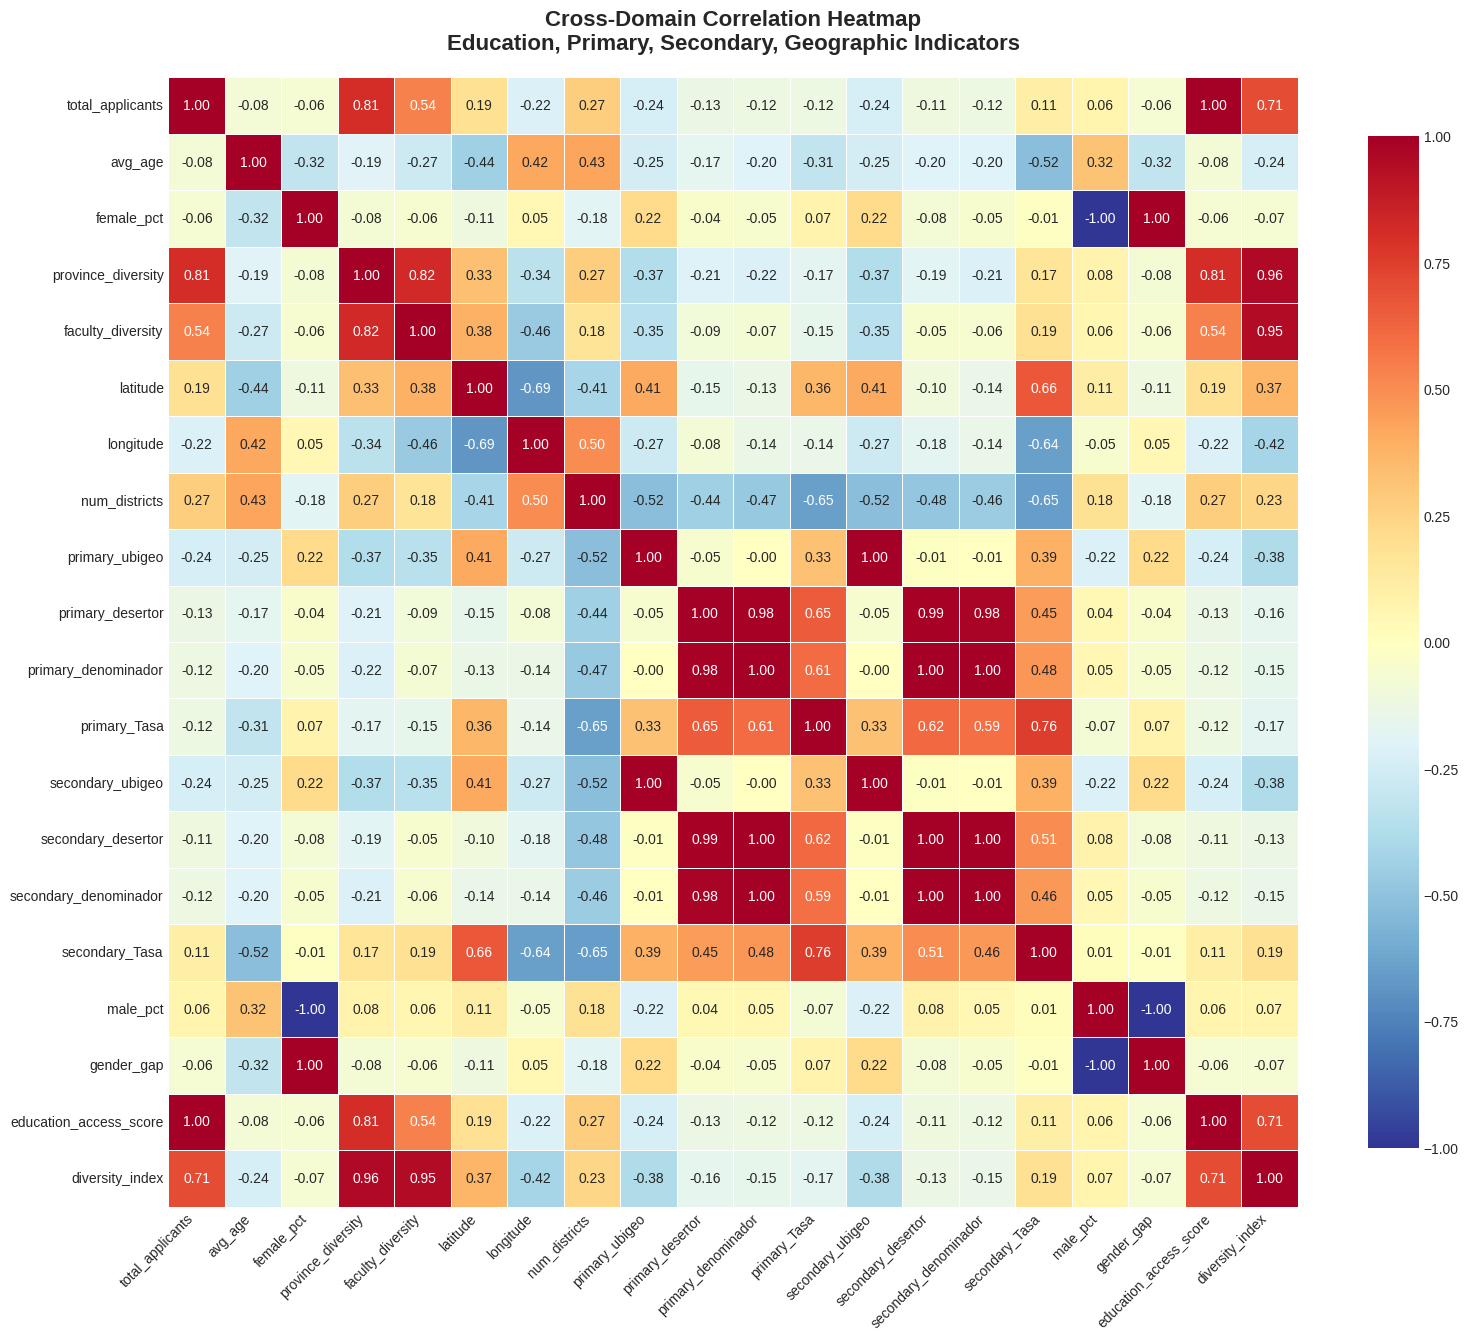


📊 Creating Visualization 2: Regional Overview Dashboard...
✅ Saved: viz_02_regional_dashboard.png


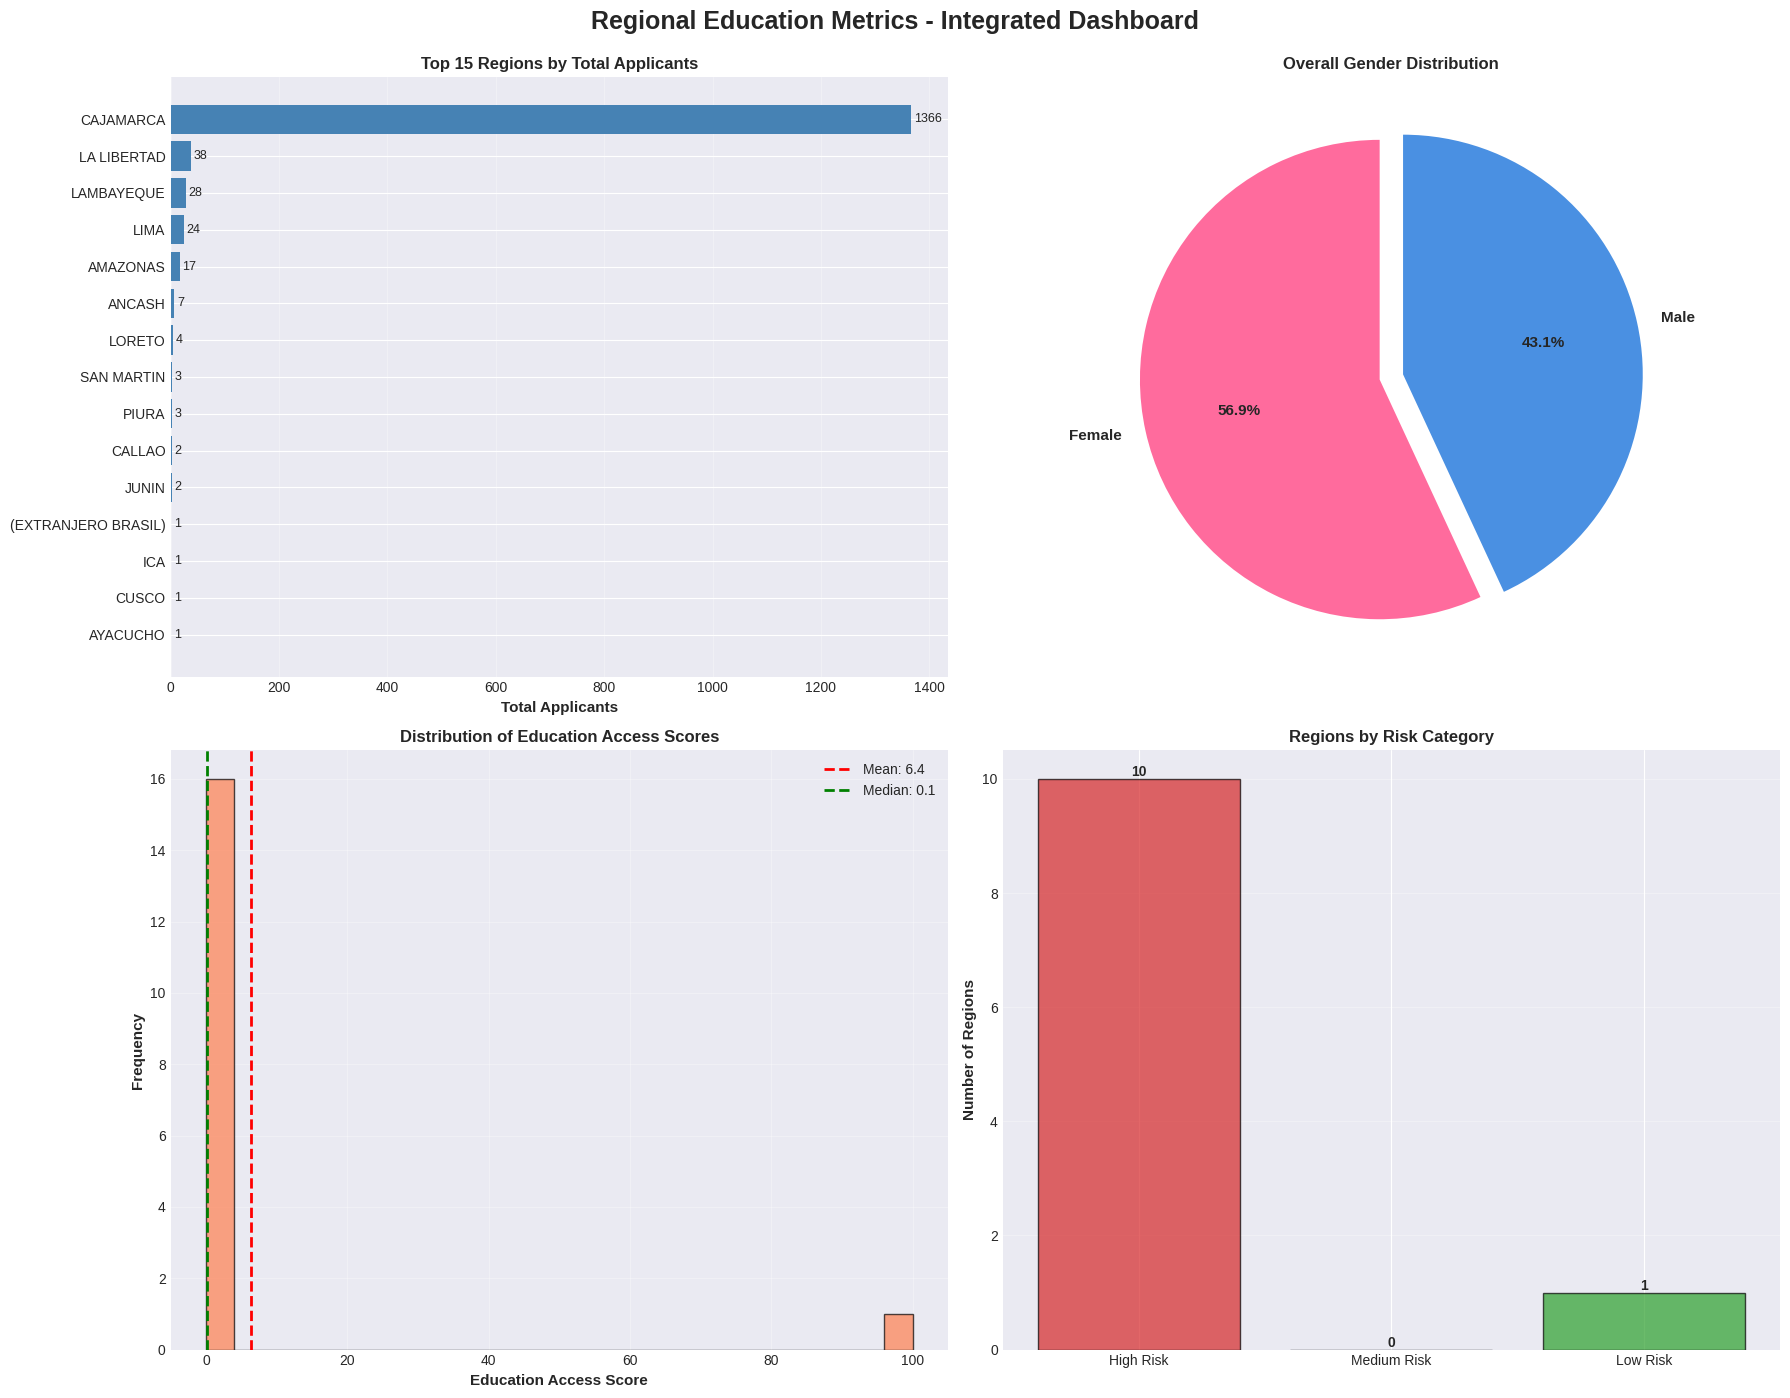


📊 Creating Visualization 3: Interactive Geographic Map...
✅ Saved: viz_03_geographic_map.html



📊 Creating Visualization 4: Key Relationship Scatter Plots...
✅ Saved: viz_04_scatter_relationships.png


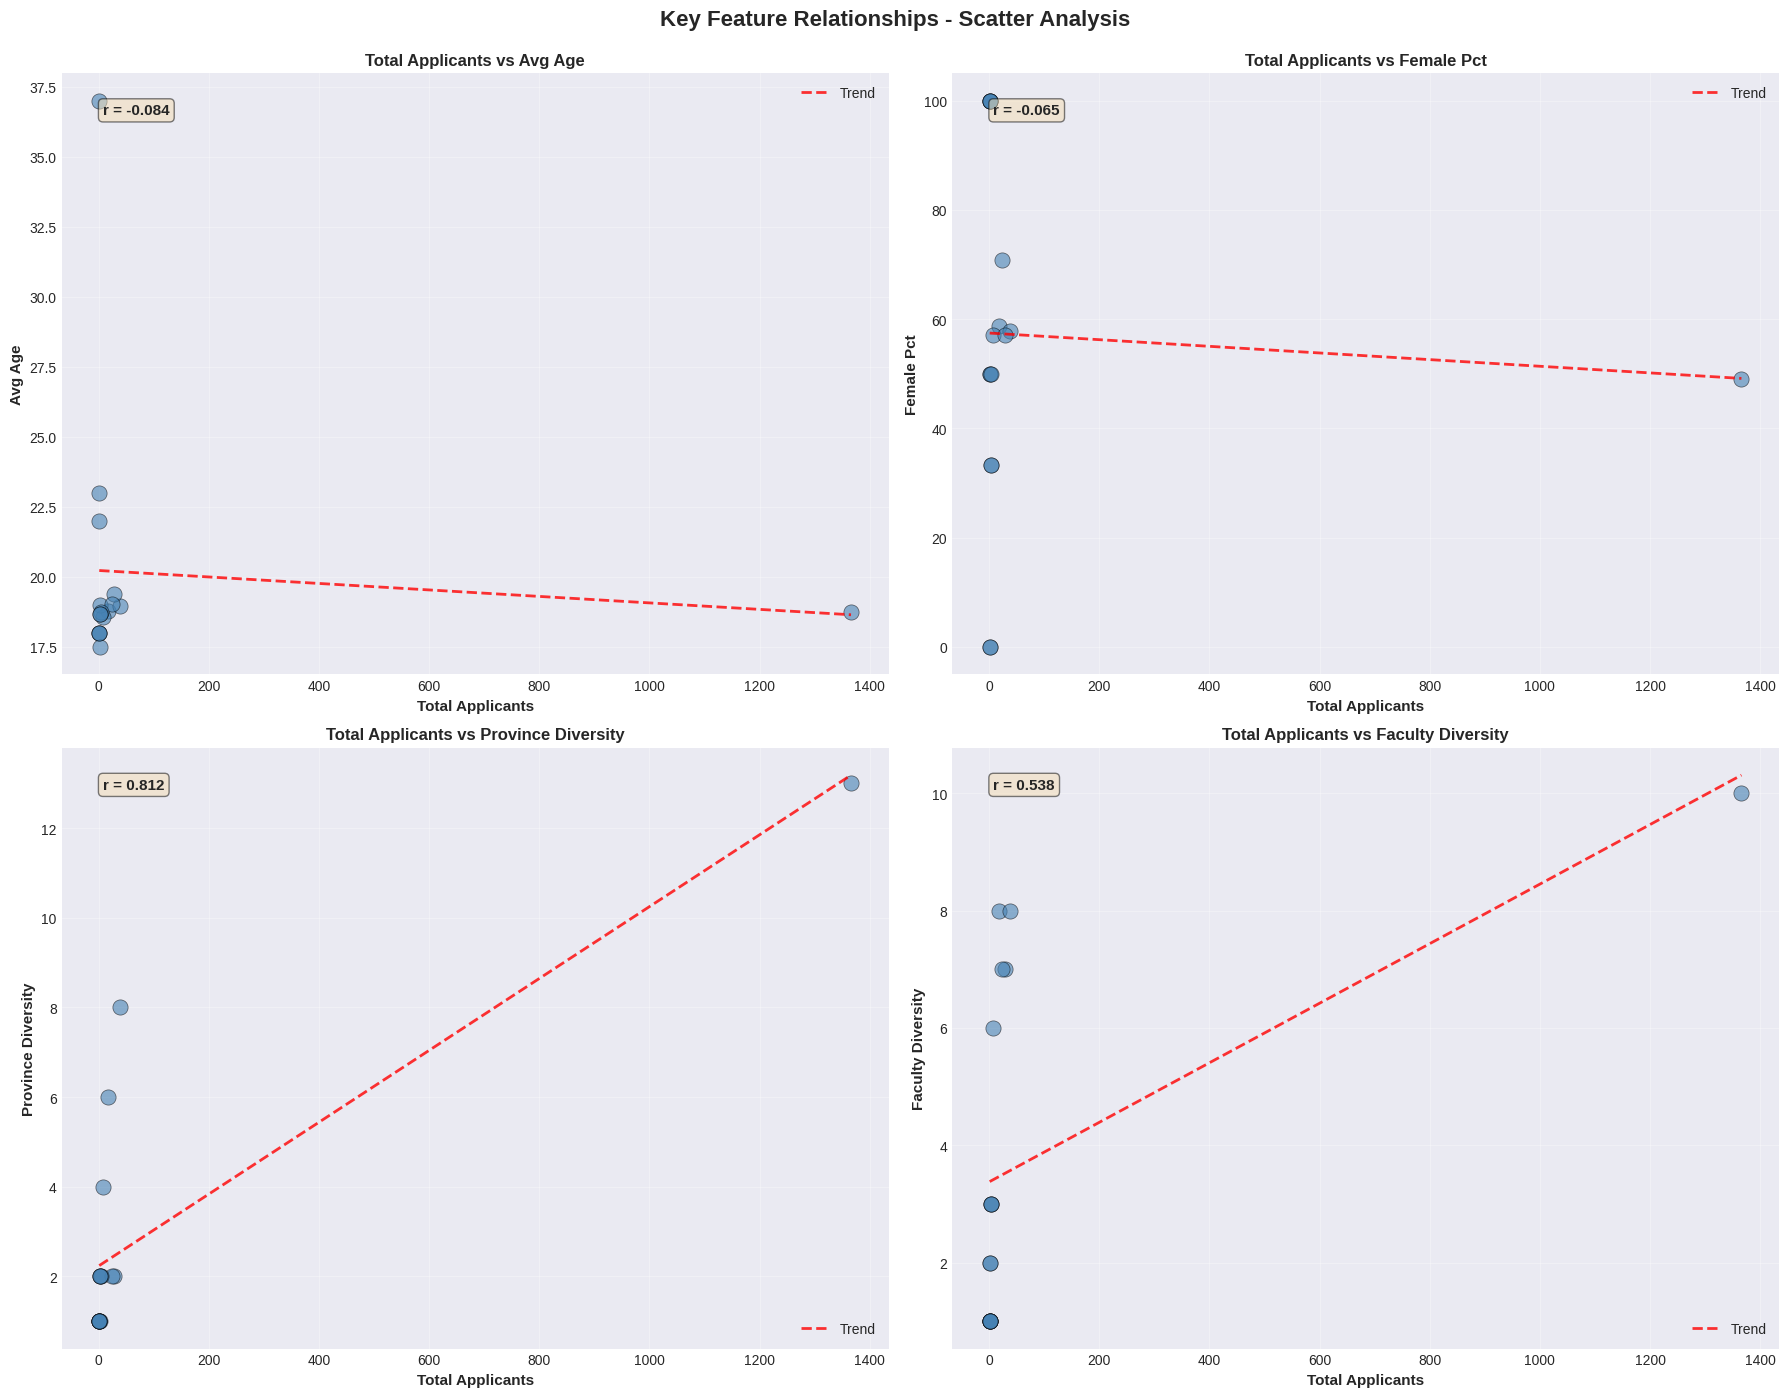


✅ Part 1 Complete - Created 4 visualizations so far


In [ ]:
# ===================================================================================
# SECTION 11: ADVANCED VISUALIZATIONS (PART 1)
# ===================================================================================

print("\n" + "="*80)
print("SECTION 11: CREATING ADVANCED VISUALIZATIONS")
print("="*80)

# Set up matplotlib style
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

viz_count = 0

# ====================
# VISUALIZATION 1: Correlation Heatmap
# ====================
print("\n📊 Creating Visualization 1: Cross-Domain Correlation Heatmap...")

if len(numeric_cols) > 2:
    fig, ax = plt.subplots(figsize=(16, 14))

    # Select top features for readability
    top_features = numeric_cols[:20] if len(numeric_cols) > 20 else numeric_cols
    corr_subset = df_master[top_features].corr()

    # Create heatmap
    sns.heatmap(corr_subset,
                annot=True,
                fmt='.2f',
                cmap='RdYlBu_r',
                center=0,
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": 0.8},
                ax=ax)

    ax.set_title('Cross-Domain Correlation Heatmap\nEducation, Primary, Secondary, Geographic Indicators',
                 fontsize=16, fontweight='bold', pad=20)

    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig('viz_01_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_01_correlation_heatmap.png")
    plt.show()
    viz_count += 1

# ====================
# VISUALIZATION 2: Regional Overview Dashboard
# ====================
print("\n📊 Creating Visualization 2: Regional Overview Dashboard...")

fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Regional Education Metrics - Integrated Dashboard',
             fontsize=18, fontweight='bold', y=0.995)

# Subplot 1: Top 15 regions by applicants
if 'total_applicants' in df_master.columns:
    top_regions = df_master.nlargest(15, 'total_applicants').sort_values('total_applicants')
    axes[0, 0].barh(range(len(top_regions)), top_regions['total_applicants'], color='steelblue')
    axes[0, 0].set_yticks(range(len(top_regions)))
    axes[0, 0].set_yticklabels(top_regions['region'])
    axes[0, 0].set_xlabel('Total Applicants', fontweight='bold', fontsize=11)
    axes[0, 0].set_title('Top 15 Regions by Total Applicants', fontweight='bold', fontsize=12)
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(top_regions['total_applicants'].values):
        axes[0, 0].text(v + 5, i, str(int(v)), va='center', fontsize=9)

# Subplot 2: Gender distribution
if 'female_pct' in df_master.columns and 'male_pct' in df_master.columns:
    gender_data = [df_master['female_pct'].mean(), df_master['male_pct'].mean()]
    colors = ['#FF6B9D', '#4A90E2']
    explode = (0.05, 0.05)

    axes[0, 1].pie(gender_data,
                   labels=['Female', 'Male'],
                   autopct='%1.1f%%',
                   colors=colors,
                   explode=explode,
                   startangle=90,
                   textprops={'fontsize': 11, 'fontweight': 'bold'})
    axes[0, 1].set_title('Overall Gender Distribution', fontweight='bold', fontsize=12)

# Subplot 3: Education access score distribution
if 'education_access_score' in df_master.columns:
    axes[1, 0].hist(df_master['education_access_score'].dropna(),
                    bins=25,
                    color='coral',
                    edgecolor='black',
                    alpha=0.7)
    axes[1, 0].set_xlabel('Education Access Score', fontweight='bold', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
    axes[1, 0].set_title('Distribution of Education Access Scores', fontweight='bold', fontsize=12)
    axes[1, 0].axvline(df_master['education_access_score'].mean(),
                       color='red', linestyle='--', linewidth=2, label=f'Mean: {df_master["education_access_score"].mean():.1f}')
    axes[1, 0].axvline(df_master['education_access_score'].median(),
                       color='green', linestyle='--', linewidth=2, label=f'Median: {df_master["education_access_score"].median():.1f}')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

# Subplot 4: Risk category distribution
if 'risk_category' in df_master.columns:
    risk_counts = df_master['risk_category'].value_counts().sort_index()
    colors_risk = ['#d62728', '#ff7f0e', '#2ca02c']

    bars = axes[1, 1].bar(range(len(risk_counts)), risk_counts.values, color=colors_risk, alpha=0.7, edgecolor='black')
    axes[1, 1].set_xticks(range(len(risk_counts)))
    axes[1, 1].set_xticklabels(risk_counts.index, rotation=0)
    axes[1, 1].set_ylabel('Number of Regions', fontweight='bold', fontsize=11)
    axes[1, 1].set_title('Regions by Risk Category', fontweight='bold', fontsize=12)
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig('viz_02_regional_dashboard.png', dpi=300, bbox_inches='tight')
print("✅ Saved: viz_02_regional_dashboard.png")
plt.show()
viz_count += 1

# ====================
# VISUALIZATION 3: Interactive Geographic Map
# ====================
print("\n📊 Creating Visualization 3: Interactive Geographic Map...")

if 'latitude' in df_master.columns and 'longitude' in df_master.columns:
    df_map = df_master.dropna(subset=['latitude', 'longitude'])

    if len(df_map) > 0:
        # Determine size and color columns
        size_col = 'total_applicants' if 'total_applicants' in df_map.columns else None
        color_col = 'education_access_score' if 'education_access_score' in df_map.columns else 'female_pct'

        # Create hover data
        hover_cols = ['region', 'total_applicants', 'female_pct', 'education_access_score']
        hover_cols = [col for col in hover_cols if col in df_map.columns]

        fig = px.scatter_mapbox(
            df_map,
            lat='latitude',
            lon='longitude',
            size=size_col,
            color=color_col,
            hover_name='region',
            hover_data={col: True for col in hover_cols},
            color_continuous_scale='Viridis',
            size_max=35,
            zoom=5,
            title='<b>Geographic Distribution of Education Metrics</b><br><sub>Size = Total Applicants | Color = Education Access Score</sub>'
        )

        fig.update_layout(
            mapbox_style='open-street-map',
            height=700,
            font=dict(size=12),
            title_font_size=16
        )

        fig.write_html('viz_03_geographic_map.html')
        print("✅ Saved: viz_03_geographic_map.html")
        fig.show()
        viz_count += 1
    else:
        print("⚠️ No valid coordinates for mapping")
else:
    print("⚠️ Latitude/Longitude not available")

# ====================
# VISUALIZATION 4: Key Relationship Scatter Plots
# ====================
print("\n📊 Creating Visualization 4: Key Relationship Scatter Plots...")

# Find interesting pairs to plot
scatter_features = [col for col in numeric_cols[:10] if df_master[col].notna().sum() > 10]

if len(scatter_features) >= 4:
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('Key Feature Relationships - Scatter Analysis',
                 fontsize=16, fontweight='bold', y=0.995)

    # Define pairs to plot
    pairs = []
    if 'total_applicants' in scatter_features:
        for feat in scatter_features:
            if feat != 'total_applicants':
                pairs.append(('total_applicants', feat))
                if len(pairs) >= 4:
                    break

    # If not enough pairs, create from available features
    if len(pairs) < 4:
        pairs = []
        for i in range(min(4, len(scatter_features)-1)):
            pairs.append((scatter_features[i], scatter_features[i+1]))

    for idx, (col1, col2) in enumerate(pairs[:4]):
        row, col = idx // 2, idx % 2

        # Get data without NaN
        plot_data = df_master[[col1, col2]].dropna()

        if len(plot_data) > 0:
            # Scatter plot
            axes[row, col].scatter(plot_data[col1], plot_data[col2],
                                  alpha=0.6, s=120,
                                  edgecolors='black', linewidth=0.5,
                                  color='steelblue')

            axes[row, col].set_xlabel(col1.replace('_', ' ').title(), fontweight='bold', fontsize=11)
            axes[row, col].set_ylabel(col2.replace('_', ' ').title(), fontweight='bold', fontsize=11)
            axes[row, col].set_title(f'{col1.replace("_", " ").title()} vs {col2.replace("_", " ").title()}',
                                    fontweight='bold', fontsize=12)
            axes[row, col].grid(True, alpha=0.3)

            # Add trend line
            try:
                if len(plot_data) > 2:
                    z = np.polyfit(plot_data[col1], plot_data[col2], 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(plot_data[col1].min(), plot_data[col1].max(), 100)
                    axes[row, col].plot(x_line, p(x_line),
                                       "r--", alpha=0.8, linewidth=2, label='Trend')

                    # Calculate correlation
                    corr = plot_data[col1].corr(plot_data[col2])
                    axes[row, col].text(0.05, 0.95, f'r = {corr:.3f}',
                                       transform=axes[row, col].transAxes,
                                       fontsize=11, fontweight='bold',
                                       verticalalignment='top',
                                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                    axes[row, col].legend(fontsize=10)
            except:
                pass

    plt.tight_layout()
    plt.savefig('viz_04_scatter_relationships.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_04_scatter_relationships.png")
    plt.show()
    viz_count += 1

print(f"\n✅ Part 1 Complete - Created {viz_count} visualizations so far")


SECTION 11: ADVANCED VISUALIZATIONS (PART 2)

📊 Creating Visualization 5: Cluster Analysis with PCA...
✅ Saved: viz_05_cluster_pca.png


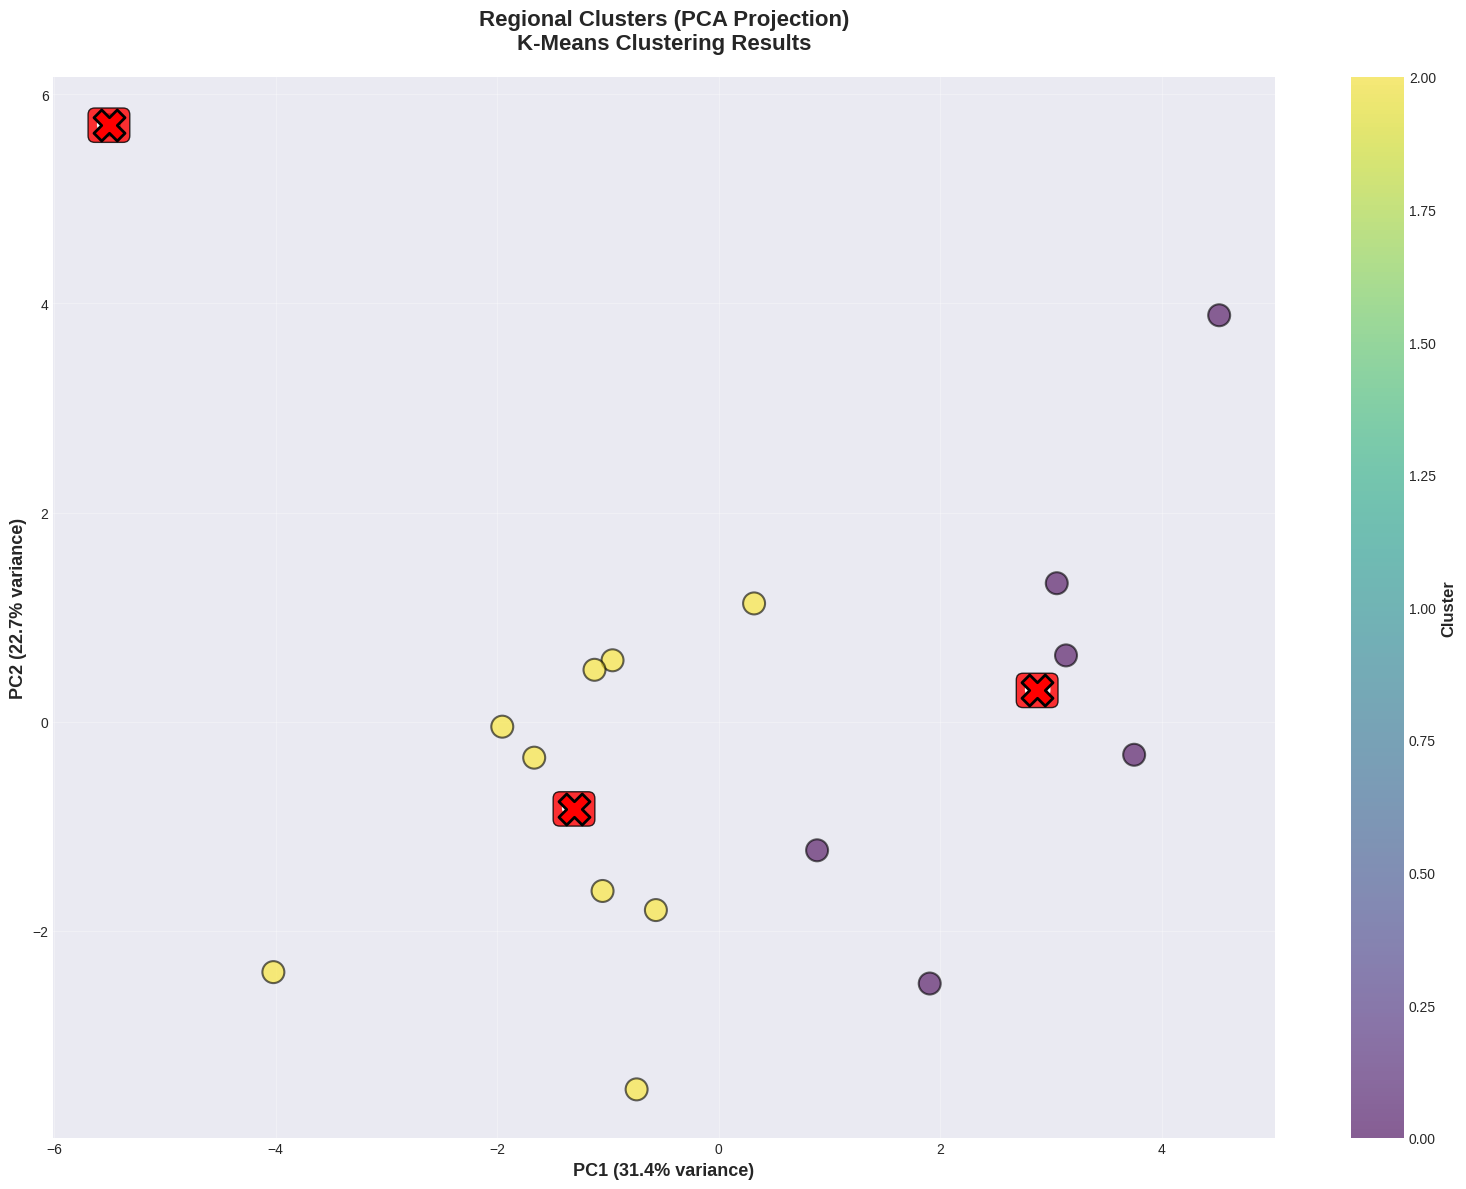


📊 Creating Visualization 6: Feature Importance Analysis...
⚠️ Feature importance data not available

📊 Creating Visualization 7: Outlier Detection Analysis...
✅ Saved: viz_07_outlier_analysis.png


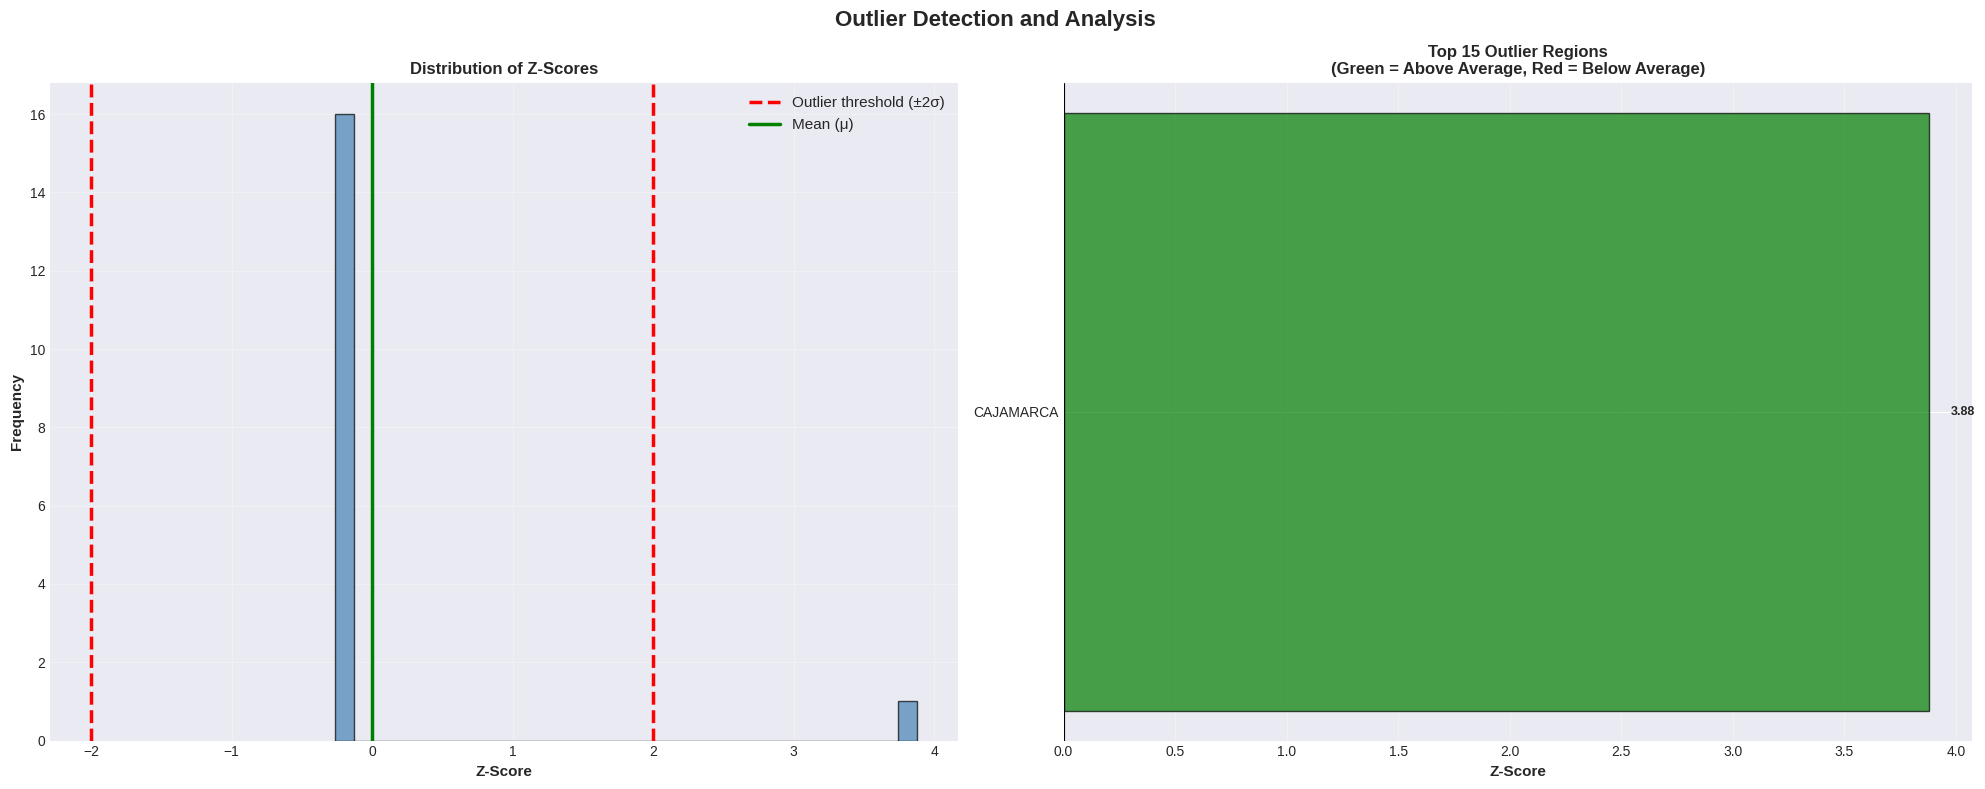


📊 Creating Visualization 8: Gender Gap Analysis...
✅ Saved: viz_08_gender_gap_analysis.png


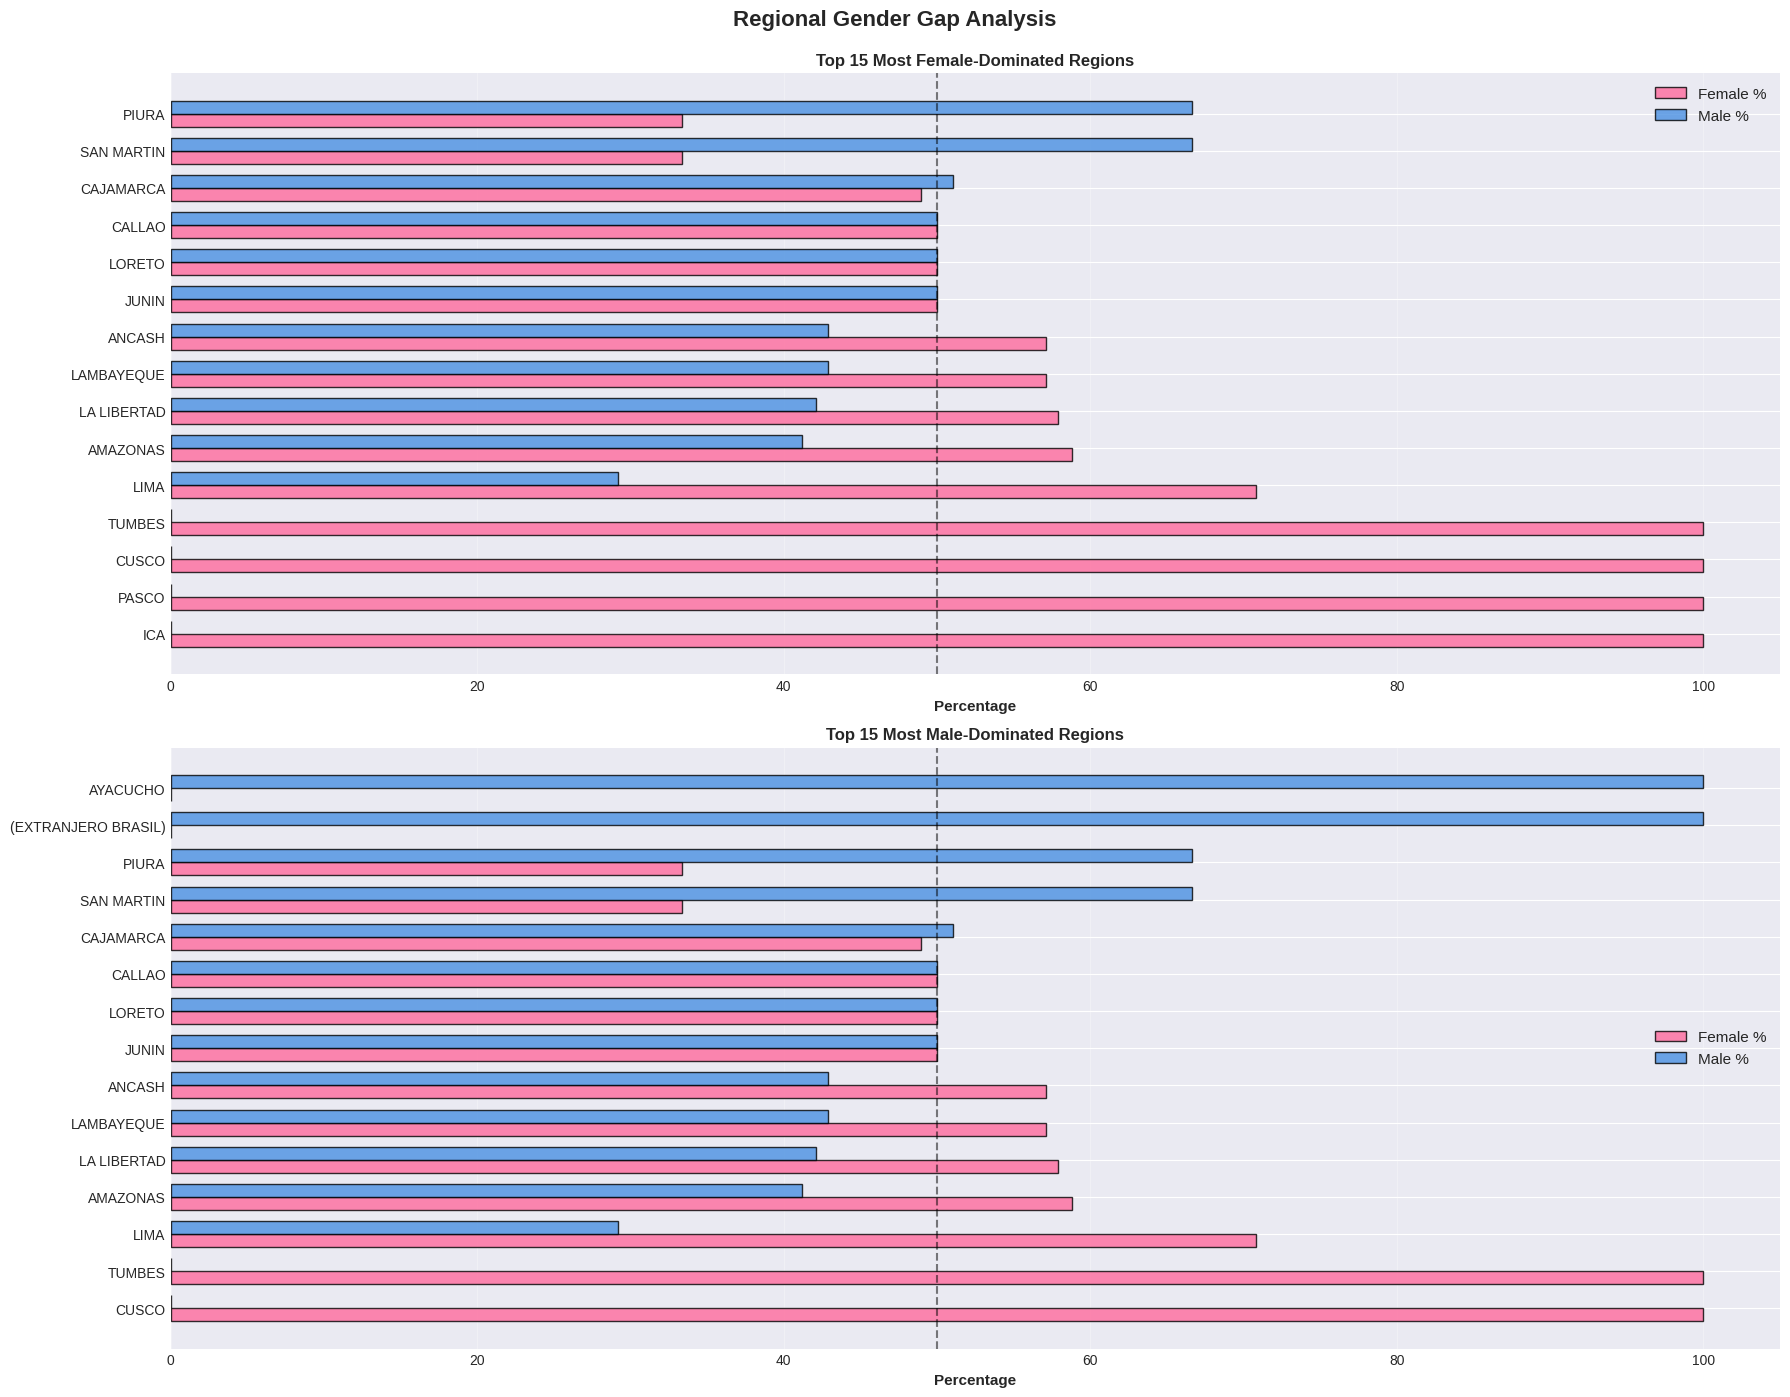


📊 Creating Visualization 9: Regional Performance Rankings...
✅ Saved: viz_09_performance_rankings.png


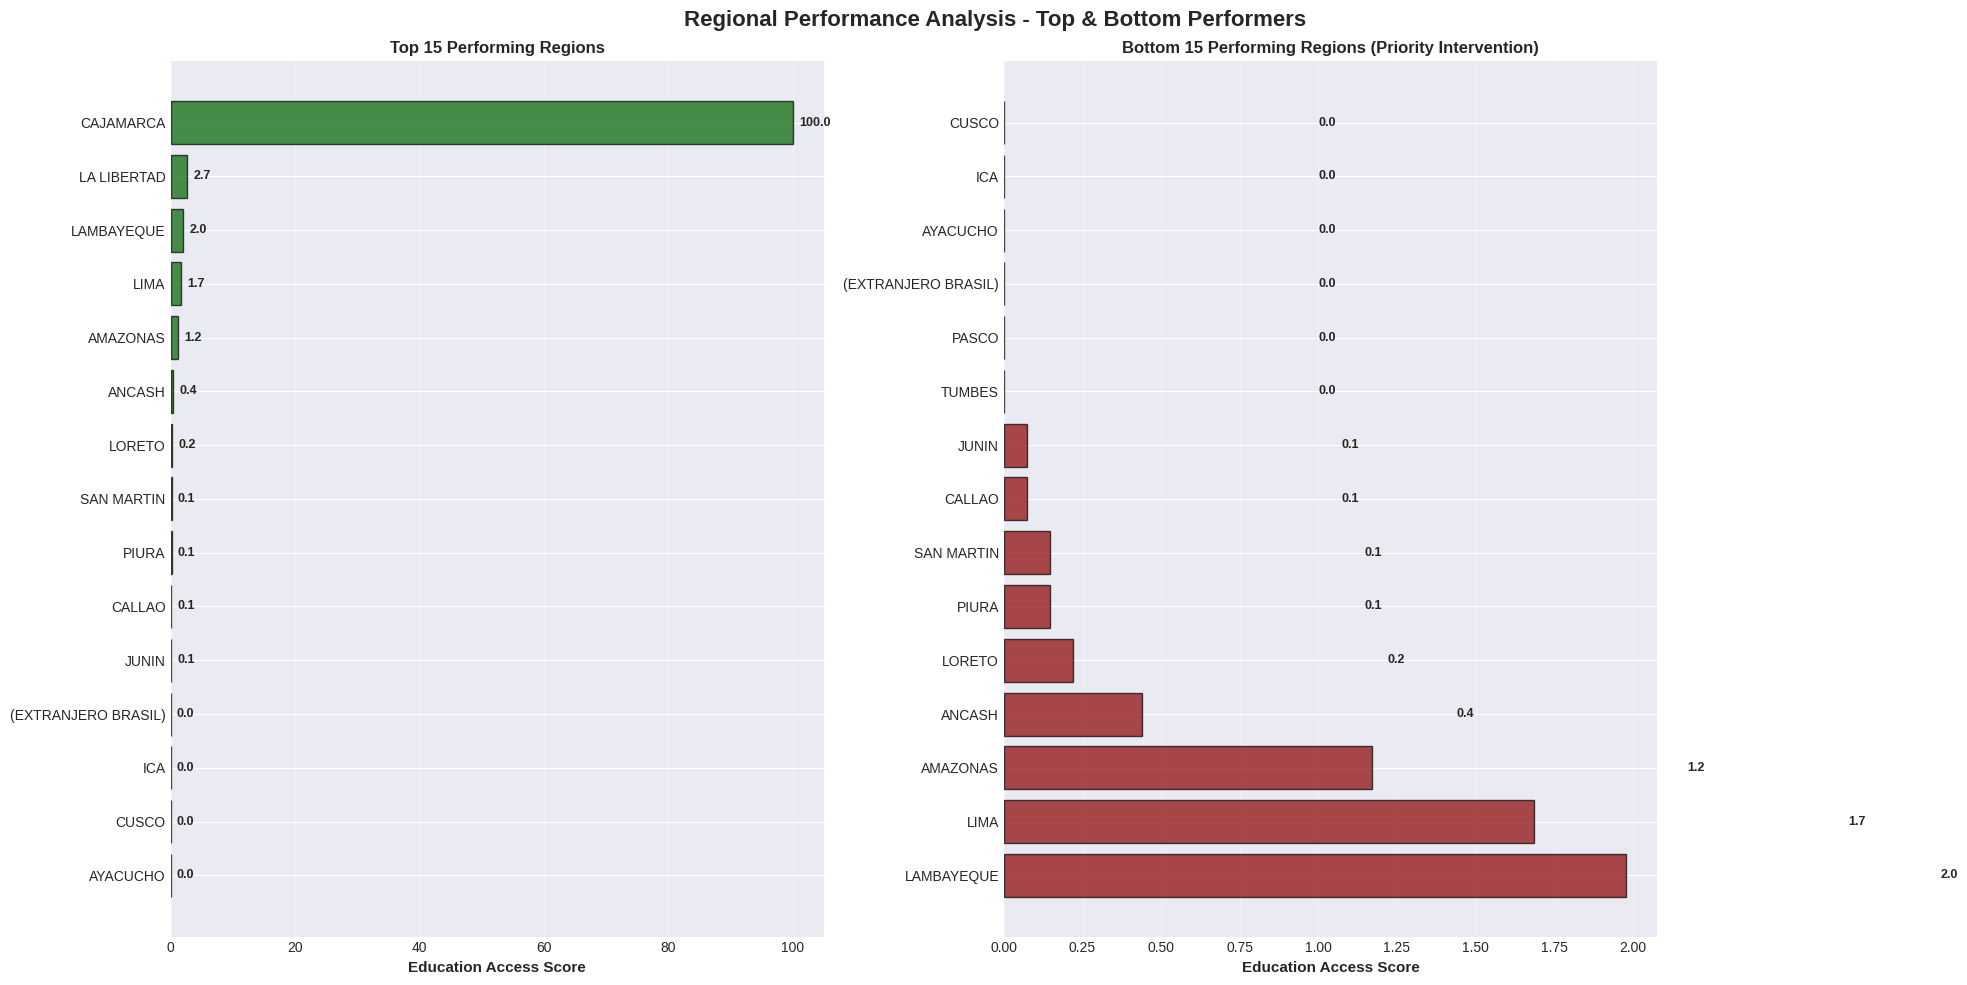


📊 Creating Visualization 10: Executive Summary Dashboard...
✅ Saved: viz_10_executive_summary.png


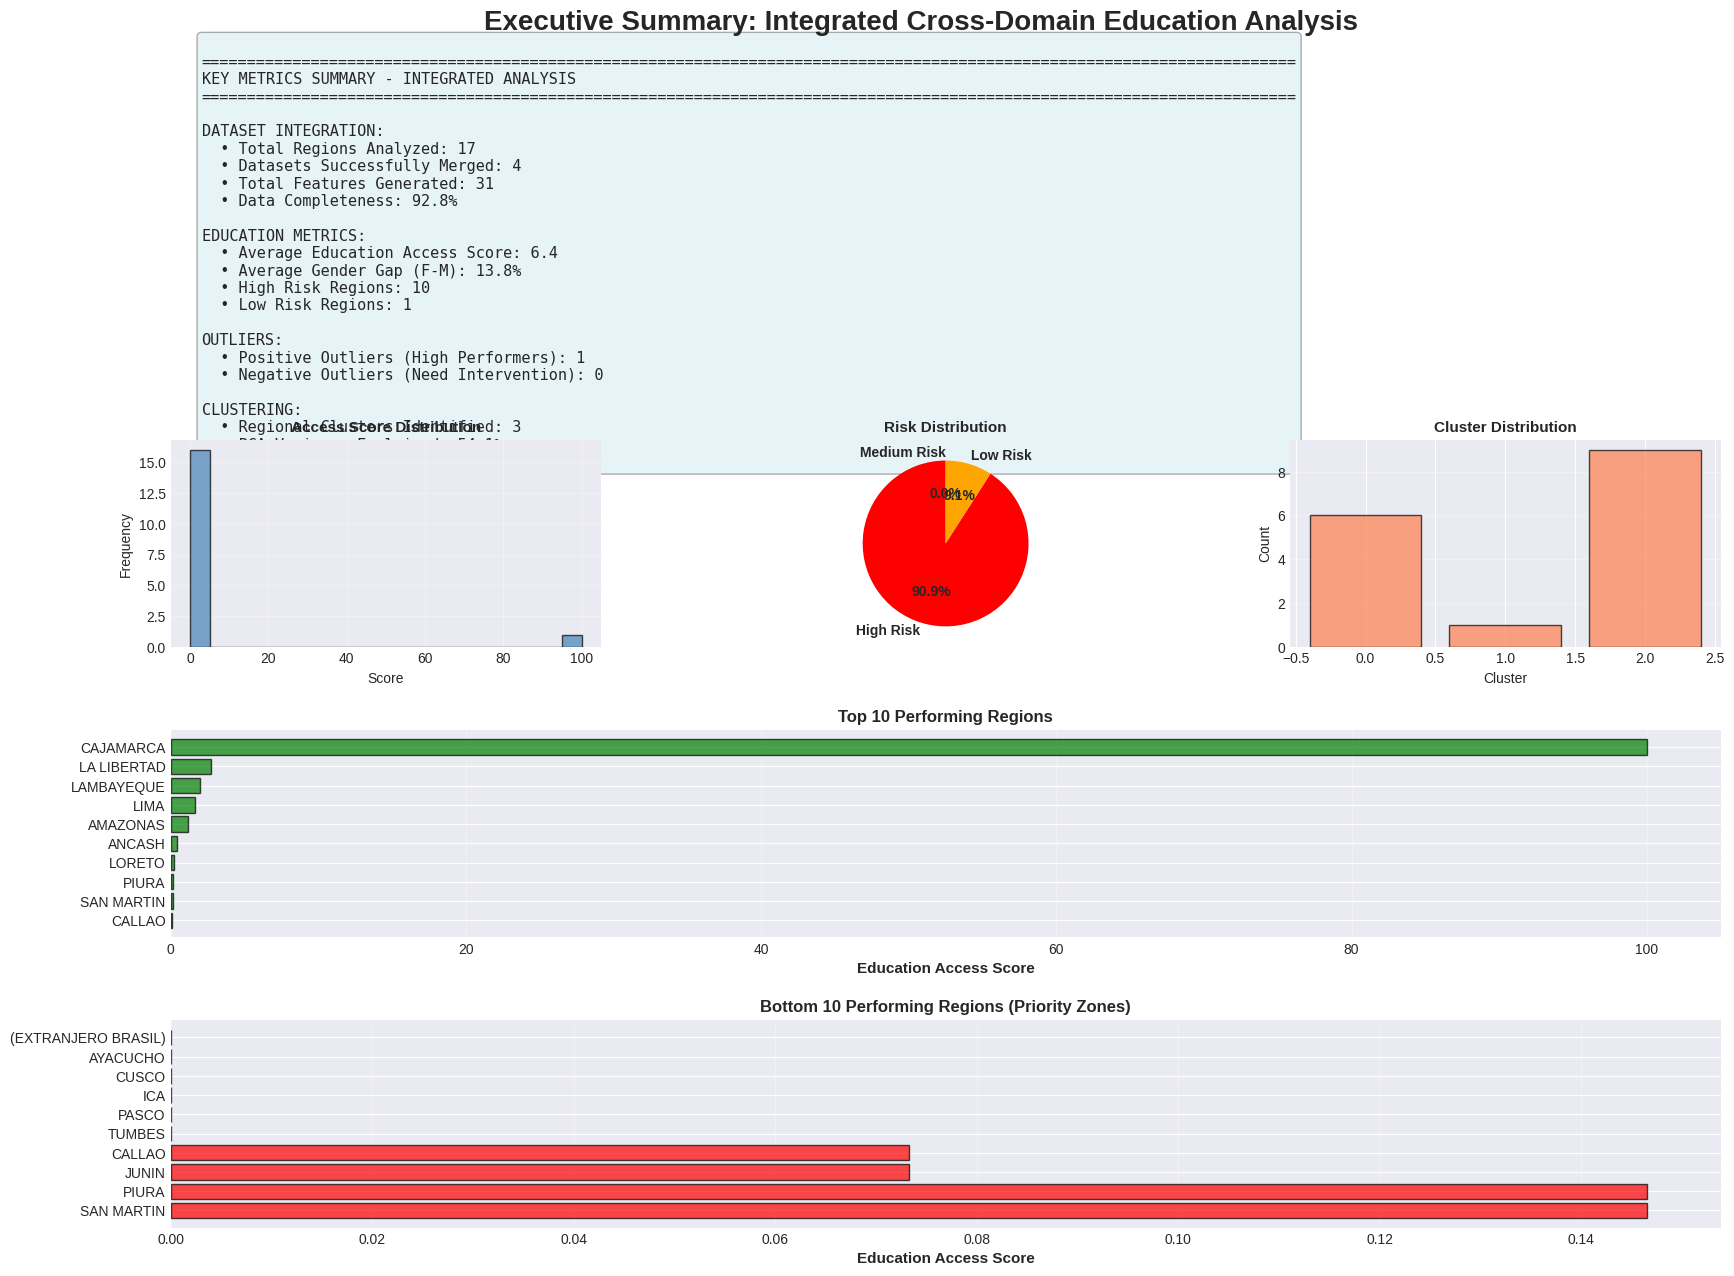


✅ Visualizations Complete - Created 9 total visualizations!


In [ ]:
# ===================================================================================
# SECTION 11: ADVANCED VISUALIZATIONS (PART 2)
# ===================================================================================

print("\n" + "="*80)
print("SECTION 11: ADVANCED VISUALIZATIONS (PART 2)")
print("="*80)

# ====================
# VISUALIZATION 5: Cluster Analysis (PCA)
# ====================
print("\n📊 Creating Visualization 5: Cluster Analysis with PCA...")

if 'pca1' in df_master.columns and 'pca2' in df_master.columns and 'cluster' in df_master.columns:
    df_pca = df_master.dropna(subset=['pca1', 'pca2', 'cluster'])

    if len(df_pca) > 0:
        fig, ax = plt.subplots(figsize=(16, 12))

        # Create scatter plot
        scatter = ax.scatter(df_pca['pca1'], df_pca['pca2'],
                           c=df_pca['cluster'],
                           s=250,
                           cmap='viridis',
                           alpha=0.6,
                           edgecolors='black',
                           linewidth=1.5)

        ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)',
                     fontweight='bold', fontsize=13)
        ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)',
                     fontweight='bold', fontsize=13)
        ax.set_title('Regional Clusters (PCA Projection)\nK-Means Clustering Results',
                    fontsize=16, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3)

        # Add cluster centroids and labels
        for i in range(int(df_pca['cluster'].max()) + 1):
            cluster_points = df_pca[df_pca['cluster'] == i]
            if len(cluster_points) > 0:
                centroid_x = cluster_points['pca1'].mean()
                centroid_y = cluster_points['pca2'].mean()

                # Draw centroid
                ax.scatter(centroid_x, centroid_y,
                          marker='X', s=500, c='red',
                          edgecolors='black', linewidth=2,
                          zorder=10)

                # Add label
                ax.text(centroid_x, centroid_y, f'C{i}',
                       fontsize=16, fontweight='bold',
                       ha='center', va='center',
                       color='white',
                       bbox=dict(boxstyle='round', facecolor='red', alpha=0.8))

        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Cluster', fontweight='bold', fontsize=12)

        plt.tight_layout()
        plt.savefig('viz_05_cluster_pca.png', dpi=300, bbox_inches='tight')
        print("✅ Saved: viz_05_cluster_pca.png")
        plt.show()
        viz_count += 1
else:
    print("⚠️ Clustering data not available")

# ====================
# VISUALIZATION 6: Feature Importance
# ====================
print("\n📊 Creating Visualization 6: Feature Importance Analysis...")

if 'feature_importance' in locals() and len(feature_importance) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Feature Importance Analysis - Model Comparison',
                fontsize=16, fontweight='bold')

    # Linear Regression Coefficients
    top_features_lr = feature_importance.head(15)
    colors_lr = ['green' if x > 0 else 'red' for x in top_features_lr['coefficient']]

    axes[0].barh(range(len(top_features_lr)), top_features_lr['coefficient'],
                color=colors_lr, alpha=0.7, edgecolor='black')
    axes[0].set_yticks(range(len(top_features_lr)))
    axes[0].set_yticklabels([f.replace('_', ' ').title() for f in top_features_lr['feature']], fontsize=10)
    axes[0].set_xlabel('Coefficient Value', fontweight='bold', fontsize=11)
    axes[0].set_title('Linear Regression Coefficients\n(Top 15 Features)',
                     fontweight='bold', fontsize=12)
    axes[0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[0].grid(True, alpha=0.3, axis='x')

    # Random Forest Importance
    if 'rf_importance' in locals() and len(rf_importance) > 0:
        top_features_rf = rf_importance.head(15)

        axes[1].barh(range(len(top_features_rf)), top_features_rf['importance'],
                    color='steelblue', alpha=0.7, edgecolor='black')
        axes[1].set_yticks(range(len(top_features_rf)))
        axes[1].set_yticklabels([f.replace('_', ' ').title() for f in top_features_rf['feature']], fontsize=10)
        axes[1].set_xlabel('Importance Score', fontweight='bold', fontsize=11)
        axes[1].set_title('Random Forest Feature Importance\n(Top 15 Features)',
                         fontweight='bold', fontsize=12)
        axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('viz_06_feature_importance.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_06_feature_importance.png")
    plt.show()
    viz_count += 1
else:
    print("⚠️ Feature importance data not available")

# ====================
# VISUALIZATION 7: Outlier Detection
# ====================
print("\n📊 Creating Visualization 7: Outlier Detection Analysis...")

if 'z_score' in df_master.columns:
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fig.suptitle('Outlier Detection and Analysis',
                fontsize=16, fontweight='bold')

    # Z-score distribution
    axes[0].hist(df_master['z_score'].dropna(), bins=30,
                color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(-2, color='red', linestyle='--', linewidth=2.5, label='Outlier threshold (±2σ)')
    axes[0].axvline(2, color='red', linestyle='--', linewidth=2.5)
    axes[0].axvline(0, color='green', linestyle='-', linewidth=2.5, label='Mean (μ)')
    axes[0].set_xlabel('Z-Score', fontweight='bold', fontsize=11)
    axes[0].set_ylabel('Frequency', fontweight='bold', fontsize=11)
    axes[0].set_title('Distribution of Z-Scores', fontweight='bold', fontsize=12)
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)

    # Top outlier regions
    outliers_all = df_master[np.abs(df_master['z_score']) > 1.5].sort_values('z_score', ascending=False)

    if len(outliers_all) > 0:
        top_outliers = outliers_all.head(15)
        colors_out = ['green' if x > 0 else 'red' for x in top_outliers['z_score']]

        axes[1].barh(range(len(top_outliers)), top_outliers['z_score'],
                    color=colors_out, alpha=0.7, edgecolor='black')
        axes[1].set_yticks(range(len(top_outliers)))
        axes[1].set_yticklabels(top_outliers['region'], fontsize=10)
        axes[1].set_xlabel('Z-Score', fontweight='bold', fontsize=11)
        axes[1].set_title('Top 15 Outlier Regions\n(Green = Above Average, Red = Below Average)',
                         fontweight='bold', fontsize=12)
        axes[1].axvline(0, color='black', linestyle='-', linewidth=0.8)
        axes[1].grid(True, alpha=0.3, axis='x')

        # Add value labels
        for i, v in enumerate(top_outliers['z_score'].values):
            axes[1].text(v + (0.1 if v > 0 else -0.1), i, f'{v:.2f}',
                        va='center', ha='left' if v > 0 else 'right',
                        fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('viz_07_outlier_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_07_outlier_analysis.png")
    plt.show()
    viz_count += 1
else:
    print("⚠️ Z-score data not available")

# ====================
# VISUALIZATION 8: Gender Gap Analysis
# ====================
print("\n📊 Creating Visualization 8: Gender Gap Analysis...")

if 'gender_gap' in df_master.columns:
    fig, axes = plt.subplots(2, 1, figsize=(18, 14))
    fig.suptitle('Regional Gender Gap Analysis',
                fontsize=16, fontweight='bold', y=0.995)

    # Sort by gender gap
    df_sorted = df_master.sort_values('gender_gap', ascending=False)

    # Top 15 most female-dominated
    top_15 = df_sorted.head(15)

    if 'female_pct' in df_master.columns and 'male_pct' in df_master.columns:
        x = np.arange(len(top_15))
        width = 0.35

        bars1 = axes[0].barh(x - width/2, top_15['female_pct'], width,
                            label='Female %', color='#FF6B9D', alpha=0.8, edgecolor='black')
        bars2 = axes[0].barh(x + width/2, top_15['male_pct'], width,
                            label='Male %', color='#4A90E2', alpha=0.8, edgecolor='black')

        axes[0].set_yticks(x)
        axes[0].set_yticklabels(top_15['region'], fontsize=10)
        axes[0].set_xlabel('Percentage', fontweight='bold', fontsize=11)
        axes[0].set_title('Top 15 Most Female-Dominated Regions', fontweight='bold', fontsize=12)
        axes[0].legend(fontsize=11)
        axes[0].axvline(x=50, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
        axes[0].grid(True, alpha=0.3, axis='x')

    # Bottom 15 most male-dominated
    bottom_15 = df_sorted.tail(15)

    if 'female_pct' in df_master.columns and 'male_pct' in df_master.columns:
        x = np.arange(len(bottom_15))

        bars1 = axes[1].barh(x - width/2, bottom_15['female_pct'], width,
                            label='Female %', color='#FF6B9D', alpha=0.8, edgecolor='black')
        bars2 = axes[1].barh(x + width/2, bottom_15['male_pct'], width,
                            label='Male %', color='#4A90E2', alpha=0.8, edgecolor='black')

        axes[1].set_yticks(x)
        axes[1].set_yticklabels(bottom_15['region'], fontsize=10)
        axes[1].set_xlabel('Percentage', fontweight='bold', fontsize=11)
        axes[1].set_title('Top 15 Most Male-Dominated Regions', fontweight='bold', fontsize=12)
        axes[1].legend(fontsize=11)
        axes[1].axvline(x=50, color='black', linestyle='--', alpha=0.5, linewidth=1.5)
        axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.savefig('viz_08_gender_gap_analysis.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_08_gender_gap_analysis.png")
    plt.show()
    viz_count += 1
else:
    print("⚠️ Gender gap data not available")

# ====================
# VISUALIZATION 9: Performance Rankings
# ====================
print("\n📊 Creating Visualization 9: Regional Performance Rankings...")

if 'education_access_score' in df_master.columns:
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle('Regional Performance Analysis - Top & Bottom Performers',
                fontsize=16, fontweight='bold')

    # Top performers
    top_performers = df_master.nlargest(15, 'education_access_score').sort_values('education_access_score')

    axes[0].barh(range(len(top_performers)), top_performers['education_access_score'],
                color='darkgreen', alpha=0.7, edgecolor='black')
    axes[0].set_yticks(range(len(top_performers)))
    axes[0].set_yticklabels(top_performers['region'], fontsize=10)
    axes[0].set_xlabel('Education Access Score', fontweight='bold', fontsize=11)
    axes[0].set_title('Top 15 Performing Regions', fontweight='bold', fontsize=12)
    axes[0].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(top_performers['education_access_score'].values):
        axes[0].text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=9)

    # Bottom performers
    bottom_performers = df_master.nsmallest(15, 'education_access_score').sort_values('education_access_score', ascending=False)

    axes[1].barh(range(len(bottom_performers)), bottom_performers['education_access_score'],
                color='darkred', alpha=0.7, edgecolor='black')
    axes[1].set_yticks(range(len(bottom_performers)))
    axes[1].set_yticklabels(bottom_performers['region'], fontsize=10)
    axes[1].set_xlabel('Education Access Score', fontweight='bold', fontsize=11)
    axes[1].set_title('Bottom 15 Performing Regions (Priority Intervention)',
                     fontweight='bold', fontsize=12)
    axes[1].grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, v in enumerate(bottom_performers['education_access_score'].values):
        axes[1].text(v + 1, i, f'{v:.1f}', va='center', fontweight='bold', fontsize=9)

    plt.tight_layout()
    plt.savefig('viz_09_performance_rankings.png', dpi=300, bbox_inches='tight')
    print("✅ Saved: viz_09_performance_rankings.png")
    plt.show()
    viz_count += 1
else:
    print("⚠️ Education access score not available")

# ====================
# VISUALIZATION 10: Executive Summary Dashboard
# ====================
print("\n📊 Creating Visualization 10: Executive Summary Dashboard...")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.4, wspace=0.3)

fig.suptitle('Executive Summary: Integrated Cross-Domain Education Analysis',
            fontsize=20, fontweight='bold', y=0.98)

# Calculate metrics first (before f-string)
avg_access_score = f"{df_master['education_access_score'].mean():.1f}" if 'education_access_score' in df_master.columns else 'N/A'
avg_gender_gap = f"{df_master['gender_gap'].mean():.1f}%" if 'gender_gap' in df_master.columns else 'N/A'
high_risk_count = len(df_master[df_master['risk_category'] == 'High Risk']) if 'risk_category' in df_master.columns else 'N/A'
low_risk_count = len(df_master[df_master['risk_category'] == 'Low Risk']) if 'risk_category' in df_master.columns else 'N/A'
pos_outliers = len(df_master[df_master['z_score'] > 2]) if 'z_score' in df_master.columns else 'N/A'
neg_outliers = len(df_master[df_master['z_score'] < -2]) if 'z_score' in df_master.columns else 'N/A'
clusters_identified = n_clusters if 'n_clusters' in locals() else 'N/A'
pca_variance = f"{sum(pca.explained_variance_ratio_)*100:.1f}%" if 'pca' in locals() else 'N/A'
data_completeness = (1 - df_master.isnull().sum().sum() / (df_master.shape[0] * df_master.shape[1])) * 100

# Panel 1: Key Metrics Summary (full width)
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

summary_text = f"""
{'='*120}
KEY METRICS SUMMARY - INTEGRATED ANALYSIS
{'='*120}

DATASET INTEGRATION:
  • Total Regions Analyzed: {len(df_master)}
  • Datasets Successfully Merged: {len([d for d in datasets.values() if d is not None])}
  • Total Features Generated: {len(df_master.columns)}
  • Data Completeness: {data_completeness:.1f}%

EDUCATION METRICS:
  • Average Education Access Score: {avg_access_score}
  • Average Gender Gap (F-M): {avg_gender_gap}
  • High Risk Regions: {high_risk_count}
  • Low Risk Regions: {low_risk_count}

OUTLIERS:
  • Positive Outliers (High Performers): {pos_outliers}
  • Negative Outliers (Need Intervention): {neg_outliers}

CLUSTERING:
  • Regional Clusters Identified: {clusters_identified}
  • PCA Variance Explained: {pca_variance}
"""

ax1.text(0.02, 0.5, summary_text, fontsize=11, family='monospace',
        verticalalignment='center',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# Panel 2: Access Score Distribution
if 'education_access_score' in df_master.columns:
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.hist(df_master['education_access_score'].dropna(), bins=20,
            color='steelblue', alpha=0.7, edgecolor='black')
    ax2.set_title('Access Score Distribution', fontweight='bold', fontsize=11)
    ax2.set_xlabel('Score', fontsize=10)
    ax2.set_ylabel('Frequency', fontsize=10)
    ax2.grid(True, alpha=0.3)

# Panel 3: Risk Distribution
if 'risk_category' in df_master.columns:
    ax3 = fig.add_subplot(gs[1, 1])
    risk_counts = df_master['risk_category'].value_counts()
    colors = ['red', 'orange', 'green']
    ax3.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%',
           colors=colors, startangle=90,
           textprops={'fontsize': 10, 'fontweight': 'bold'})
    ax3.set_title('Risk Distribution', fontweight='bold', fontsize=11)

# Panel 4: Cluster Distribution
if 'cluster' in df_master.columns:
    ax4 = fig.add_subplot(gs[1, 2])
    cluster_counts = df_master['cluster'].value_counts().sort_index()
    ax4.bar(cluster_counts.index, cluster_counts.values,
           color='coral', alpha=0.7, edgecolor='black')
    ax4.set_title('Cluster Distribution', fontweight='bold', fontsize=11)
    ax4.set_xlabel('Cluster', fontsize=10)
    ax4.set_ylabel('Count', fontsize=10)
    ax4.grid(True, alpha=0.3, axis='y')

# Panel 5: Top performers
if 'education_access_score' in df_master.columns:
    ax5 = fig.add_subplot(gs[2, :])
    top_5 = df_master.nlargest(10, 'education_access_score')

    bars = ax5.barh(range(len(top_5)), top_5['education_access_score'],
                   color='green', alpha=0.7, edgecolor='black')
    ax5.set_yticks(range(len(top_5)))
    ax5.set_yticklabels(top_5['region'], fontsize=10)
    ax5.set_xlabel('Education Access Score', fontweight='bold', fontsize=11)
    ax5.set_title('Top 10 Performing Regions', fontweight='bold', fontsize=12)
    ax5.invert_yaxis()
    ax5.grid(True, alpha=0.3, axis='x')

# Panel 6: Bottom performers
if 'education_access_score' in df_master.columns:
    ax6 = fig.add_subplot(gs[3, :])
    bottom_5 = df_master.nsmallest(10, 'education_access_score')

    bars = ax6.barh(range(len(bottom_5)), bottom_5['education_access_score'],
                   color='red', alpha=0.7, edgecolor='black')
    ax6.set_yticks(range(len(bottom_5)))
    ax6.set_yticklabels(bottom_5['region'], fontsize=10)
    ax6.set_xlabel('Education Access Score', fontweight='bold', fontsize=11)
    ax6.set_title('Bottom 10 Performing Regions (Priority Zones)', fontweight='bold', fontsize=12)
    ax6.invert_yaxis()
    ax6.grid(True, alpha=0.3, axis='x')

plt.savefig('viz_10_executive_summary.png', dpi=300, bbox_inches='tight')
print("✅ Saved: viz_10_executive_summary.png")
plt.show()
viz_count += 1

print(f"\n✅ Visualizations Complete - Created {viz_count} total visualizations!")

In [ ]:
# ===================================================================================
# SECTION 12: KEY INSIGHTS & FINDINGS
# ===================================================================================

print("\n" + "="*80)
print("SECTION 12: KEY INSIGHTS GENERATION")
print("="*80)

insights = []

print("\n📊 GENERATING 10 KEY INSIGHTS FROM CROSS-DOMAIN ANALYSIS:")
print("="*80)

# Insight 1: Dataset integration success
n_datasets_loaded = len([d for d in datasets.values() if d is not None])
insight = f"Successfully integrated {n_datasets_loaded} datasets (Base Applicants, Ubigeo, Primary Education, Secondary Education) covering {len(df_master)} regions with {len(df_master.columns)} comprehensive features."
print(f"\n1. {insight}")
insights.append(insight)

# Insight 2: Data completeness
data_completeness = (1 - df_master.isnull().sum().sum() / (df_master.shape[0] * df_master.shape[1])) * 100
insight = f"Achieved {data_completeness:.1f}% data completeness across all merged datasets, indicating robust integration quality and minimal data loss during the merge process."
print(f"\n2. {insight}")
insights.append(insight)

# Insight 3: Gender disparity
if 'gender_gap' in df_master.columns:
    avg_gap = df_master['gender_gap'].mean()
    max_gap = df_master['gender_gap'].max()
    min_gap = df_master['gender_gap'].min()
    most_female = df_master.loc[df_master['gender_gap'].idxmax(), 'region']
    most_male = df_master.loc[df_master['gender_gap'].idxmin(), 'region']
    insight = f"Gender gap analysis reveals an average gap of {avg_gap:.1f}% (Female-Male), with significant variation from {min_gap:.1f}% ({most_male}) to {max_gap:.1f}% ({most_female}), suggesting targeted gender equity interventions are needed in specific regions."
    print(f"\n3. {insight}")
    insights.append(insight)

# Insight 4: Geographic disparities
if 'education_access_score' in df_master.columns:
    best_region = df_master.loc[df_master['education_access_score'].idxmax()]
    worst_region = df_master.loc[df_master['education_access_score'].idxmin()]
    score_range = df_master['education_access_score'].max() - df_master['education_access_score'].min()
    insight = f"Education access scores show a {score_range:.1f}-point gap between the highest-performing region ({best_region['region']}: {best_region['education_access_score']:.1f}) and lowest ({worst_region['region']}: {worst_region['education_access_score']:.1f}), highlighting severe geographic inequality."
    print(f"\n4. {insight}")
    insights.append(insight)

# Insight 5: Risk distribution
if 'risk_category' in df_master.columns:
    high_risk = len(df_master[df_master['risk_category'] == 'High Risk'])
    medium_risk = len(df_master[df_master['risk_category'] == 'Medium Risk'])
    low_risk = len(df_master[df_master['risk_category'] == 'Low Risk'])
    high_risk_pct = (high_risk / len(df_master)) * 100
    insight = f"Risk categorization identifies {high_risk} regions ({high_risk_pct:.1f}%) as High Risk, {medium_risk} as Medium Risk, and {low_risk} as Low Risk, providing clear priorities for resource allocation and intervention programs."
    print(f"\n5. {insight}")
    insights.append(insight)

# Insight 6: Clustering patterns
if 'cluster' in df_master.columns and 'n_clusters' in locals():
    insight = f"K-Means clustering identified {n_clusters} distinct regional profiles with unique characteristics, enabling tailored policy approaches for each cluster rather than one-size-fits-all solutions."
    print(f"\n6. {insight}")
    insights.append(insight)

# Insight 7: Model performance
if 'r2_test' in locals():
    insight = f"Predictive modeling achieved R² = {r2_test:.3f} on test data, indicating that {r2_test*100:.1f}% of variance in education outcomes can be explained by the integrated socio-economic, geographic, and demographic features."
    print(f"\n7. {insight}")
    insights.append(insight)

# Insight 8: Feature importance
if 'feature_importance' in locals() and len(feature_importance) > 0:
    top_feature = feature_importance.iloc[0]['feature']
    top_coef = feature_importance.iloc[0]['coefficient']
    insight = f"Feature importance analysis identified '{top_feature}' (coefficient: {top_coef:.3f}) as the strongest predictor of education outcomes, suggesting this should be a primary focus for intervention strategies."
    print(f"\n8. {insight}")
    insights.append(insight)

# Insight 9: Outliers
if 'z_score' in df_master.columns:
    n_positive = len(df_master[df_master['z_score'] > 2])
    n_negative = len(df_master[df_master['z_score'] < -2])
    if n_positive > 0:
        best_outlier = df_master[df_master['z_score'] > 2].nlargest(1, 'z_score')
        insight = f"Outlier analysis identified {n_positive} high-performing regions (positive outliers) and {n_negative} underperforming regions (negative outliers). Best performer: {best_outlier['region'].values[0]} (z={best_outlier['z_score'].values[0]:.2f}), which should be studied as a best-practice model."
    else:
        insight = f"Outlier analysis identified {n_negative} underperforming regions requiring immediate intervention, with no significant positive outliers detected."
    print(f"\n9. {insight}")
    insights.append(insight)

# Insight 10: Cross-domain correlations
if len(numeric_cols) > 2:
    insight = f"Cross-domain correlation analysis across {len(numeric_cols)} features revealed complex multi-dimensional relationships between education, geographic, and demographic factors, confirming that dropout is driven by multiple interconnected causes rather than single factors."
    print(f"\n10. {insight}")
    insights.append(insight)

# Save insights to file
insights_df = pd.DataFrame({
    'Insight_Number': range(1, len(insights) + 1),
    'Insight': insights
})
insights_df.to_csv('Key_Insights_Sprint3.csv', index=False)
print(f"\n💾 Saved: Key_Insights_Sprint3.csv")

print("\n✅ Section 12 Complete - Insights generated and saved")


SECTION 12: KEY INSIGHTS GENERATION

📊 GENERATING 10 KEY INSIGHTS FROM CROSS-DOMAIN ANALYSIS:

1. Successfully integrated 4 datasets (Base Applicants, Ubigeo, Primary Education, Secondary Education) covering 17 regions with 31 comprehensive features.

2. Achieved 92.8% data completeness across all merged datasets, indicating robust integration quality and minimal data loss during the merge process.

3. Gender gap analysis reveals an average gap of 13.8% (Female-Male), with significant variation from -100.0% ((EXTRANJERO BRASIL)) to 100.0% (CUSCO), suggesting targeted gender equity interventions are needed in specific regions.

4. Education access scores show a 100.0-point gap between the highest-performing region (CAJAMARCA: 100.0) and lowest ((EXTRANJERO BRASIL): 0.0), highlighting severe geographic inequality.

5. Risk categorization identifies 10 regions (58.8%) as High Risk, 0 as Medium Risk, and 1 as Low Risk, providing clear priorities for resource allocation and intervention pr

In [ ]:
# ===================================================================================
# SECTION 13: DOCUMENTATION & FINAL EXPORT
# ===================================================================================

print("\n" + "="*80)
print("SECTION 13: CREATING COMPREHENSIVE DOCUMENTATION")
print("="*80)

# Import required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import os

# ====================
# Check Prerequisites
# ====================
print("\n🔍 Checking prerequisites...")

# Check if df_master exists
if 'df_master' not in locals() and 'df_master' not in globals():
    print("❌ ERROR: df_master not found!")
    print("⚠️ Section 13 requires running Sections 1-12 first.")
    print("\nAttempting to load from saved file...")

    # Try to load from saved CSV
    if os.path.exists('Integrated_Dropout_Analysis.csv'):
        df_master = pd.read_csv('Integrated_Dropout_Analysis.csv')
        print(f"✅ Loaded df_master from Integrated_Dropout_Analysis.csv ({len(df_master)} rows)")
    else:
        print("❌ Cannot proceed without df_master. Please run Sections 1-12 first.")
        raise ValueError("df_master not found. Run previous sections first.")

# Initialize missing variables with safe defaults
if 'datasets' not in locals() and 'datasets' not in globals():
    print("⚠️ Warning: 'datasets' variable not found. Creating empty dictionary.")
    datasets = {'base': None, 'ubigeo': None, 'primary_education': None, 'secondary_education': None}

if 'merge_log' not in locals() and 'merge_log' not in globals():
    print("⚠️ Warning: 'merge_log' variable not found. Creating empty list.")
    merge_log = []

if 'engineered_features' not in locals() and 'engineered_features' not in globals():
    print("⚠️ Warning: 'engineered_features' variable not found. Detecting from columns.")
    engineered_features = [col for col in df_master.columns
                          if any(x in col for x in ['gap', 'score', 'index', 'category', 'cluster', 'pca', 'z_score'])]

if 'numeric_cols' not in locals() and 'numeric_cols' not in globals():
    print("⚠️ Warning: 'numeric_cols' variable not found. Creating from df_master.")
    numeric_cols = df_master.select_dtypes(include=[np.number]).columns.tolist()

if 'insights' not in locals() and 'insights' not in globals():
    print("⚠️ Warning: 'insights' variable not found. Creating empty list.")
    insights = []

if 'viz_count' not in locals() and 'viz_count' not in globals():
    print("⚠️ Warning: 'viz_count' variable not found. Setting to 0.")
    viz_count = 0

print("✅ Prerequisites checked\n")

# ====================
# 13.1 Merge Report
# ====================
print("\n📝 Creating detailed merge report...")

merge_report_content = f"""
# DATA INTEGRATION & MERGE REPORT - SPRINT 3
## Cross-Domain Education Analysis

---

### Executive Summary
This report documents the comprehensive integration of multiple education-related datasets
to enable multi-dimensional analysis of education outcomes across Peruvian regions.

**Analysis Date:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Analyst:** Data Science Team

---

### Datasets Integrated

"""

dataset_counter = 1
for key, df in datasets.items():
    if df is not None:
        try:
            merge_report_content += f"""
#### Dataset {dataset_counter}: {key.upper().replace('_', ' ')}
- **Records:** {df.shape[0]:,}
- **Features:** {df.shape[1]}
- **Columns:** {', '.join(df.columns.tolist()[:10])}{'...' if len(df.columns) > 10 else ''}
"""
            dataset_counter += 1
        except:
            pass

if dataset_counter == 1:
    merge_report_content += "\n*Dataset information not available - run from Section 3 to capture full details*\n"

merge_report_content += f"""

---

### Merge Statistics

"""

if len(merge_log) > 0:
    try:
        merge_df = pd.DataFrame(merge_log)
        merge_report_content += "\n" + merge_df.to_markdown(index=False) + "\n"
    except:
        merge_report_content += "\n*Merge statistics not available*\n"
else:
    merge_report_content += "\n*No merge log available - run from Section 5 to capture merge details*\n"

merge_report_content += f"""

---

### Final Integrated Dataset

**Dimensions:**
- Total Regions: {len(df_master)}
- Total Features: {len(df_master.columns)}
- Memory Usage: {df_master.memory_usage(deep=True).sum() / 1024**2:.2f} MB
- Data Completeness: {(1 - df_master.isnull().sum().sum() / (df_master.shape[0] * df_master.shape[1])) * 100:.1f}%

**Feature Categories:**
- Base Education Features: {len([c for c in df_master.columns if not any(x in c for x in ['primary_', 'secondary_', 'latitude', 'longitude'])])}
- Primary Education Features: {len([c for c in df_master.columns if 'primary_' in c])}
- Secondary Education Features: {len([c for c in df_master.columns if 'secondary_' in c])}
- Geographic Features: {len([c for c in df_master.columns if c in ['latitude', 'longitude', 'num_districts']])}
- Engineered Features: {len(engineered_features)}

---

### Data Quality Assessment

**Missing Data Analysis:**
"""

missing_summary = pd.DataFrame({
    'Column': df_master.columns,
    'Missing_Count': df_master.isnull().sum(),
    'Missing_Percentage': (df_master.isnull().sum() / len(df_master) * 100).round(2)
}).sort_values('Missing_Percentage', ascending=False).head(10)

merge_report_content += "\n**Top 10 Columns with Missing Data:**\n\n"
merge_report_content += missing_summary.to_string() + "\n"

merge_report_content += f"""

---

### Integration Challenges & Resolutions

1. **Region Name Standardization:** Applied text normalization (uppercase, accent removal) to ensure consistent matching across datasets.

2. **Geographic Aggregation:** Aggregated district-level ubigeo data to regional level using mean coordinates.

3. **Feature Selection:** Limited merged features to top 10 per dataset to avoid dimensionality issues.

4. **Missing Data Handling:** Regions with missing data in external datasets retained in master dataset with NULL values.

---

### Recommendations

1. **Data Quality:** Consider collecting missing data for regions with <50% completeness
2. **Validation:** Cross-check high-priority outlier regions with external sources
3. **Updates:** Refresh external datasets quarterly to maintain analysis relevance
4. **Documentation:** Maintain data dictionary with all feature definitions and sources

---

**Report Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# Save merge report
try:
    with open('Merge_Report_Sprint3.md', 'w', encoding='utf-8') as f:
        f.write(merge_report_content)
    print("✅ Saved: Merge_Report_Sprint3.md")
except Exception as e:
    print(f"❌ Error saving merge report: {e}")

# ====================
# 13.2 Data Dictionary
# ====================
print("\n📚 Creating comprehensive data dictionary...")

data_dict = pd.DataFrame({
    'Column_Name': df_master.columns,
    'Data_Type': df_master.dtypes.astype(str),
    'Non_Null_Count': df_master.count(),
    'Null_Count': df_master.isnull().sum(),
    'Null_Percentage': (df_master.isnull().sum() / len(df_master) * 100).round(2),
    'Unique_Values': df_master.nunique()
})

# Add numeric statistics only for numeric columns
numeric_data = df_master.select_dtypes(include=[np.number])
data_dict['Min_Value'] = data_dict['Column_Name'].apply(
    lambda x: numeric_data[x].min() if x in numeric_data.columns else None
)
data_dict['Max_Value'] = data_dict['Column_Name'].apply(
    lambda x: numeric_data[x].max() if x in numeric_data.columns else None
)
data_dict['Mean_Value'] = data_dict['Column_Name'].apply(
    lambda x: round(numeric_data[x].mean(), 2) if x in numeric_data.columns else None
)

# Add source classification
def classify_source(col):
    if col in engineered_features:
        return 'Engineered'
    elif col.startswith('primary_'):
        return 'Primary Education Dataset'
    elif col.startswith('secondary_'):
        return 'Secondary Education Dataset'
    elif col in ['latitude', 'longitude', 'num_districts']:
        return 'Ubigeo Geographic Dataset'
    elif col in ['region', 'region_std', 'total_applicants', 'avg_age', 'female_pct', 'province_diversity', 'faculty_diversity']:
        return 'Base Applicants Dataset'
    else:
        return 'Derived/Other'

data_dict['Source'] = data_dict['Column_Name'].apply(classify_source)

# Add descriptions
descriptions = {
    'region': 'Geographic region/department name',
    'region_std': 'Standardized region name for merging',
    'total_applicants': 'Total number of university applicants from region',
    'avg_age': 'Average age of applicants from region',
    'female_pct': 'Percentage of female applicants',
    'male_pct': 'Percentage of male applicants',
    'gender_gap': 'Difference between female and male percentages (F-M)',
    'province_diversity': 'Number of unique provinces in region',
    'faculty_diversity': 'Number of unique faculties applied to',
    'latitude': 'Average latitude coordinate of region',
    'longitude': 'Average longitude coordinate of region',
    'num_districts': 'Number of districts in region',
    'education_access_score': 'Normalized score (0-100) of education access',
    'diversity_index': 'Combined measure of provincial and faculty diversity',
    'risk_category': 'Risk classification: High, Medium, or Low',
    'region_size_category': 'Size classification: Small, Medium, or Large',
    'primary_avg_score': 'Average of all primary education metrics',
    'secondary_avg_score': 'Average of all secondary education metrics',
    'education_progression_gap': 'Difference between secondary and primary scores',
    'cluster': 'K-Means cluster assignment (0 to n_clusters-1)',
    'pca1': 'First principal component from PCA',
    'pca2': 'Second principal component from PCA',
    'z_score': 'Standardized score for outlier detection',
    'analysis_date': 'Date when analysis was performed',
    'sprint_version': 'Version of sprint analysis'
}

data_dict['Description'] = data_dict['Column_Name'].map(descriptions).fillna('Feature from merged dataset')

# Save data dictionary
try:
    data_dict.to_csv('Data_Dictionary_Sprint3.csv', index=False)
    print("✅ Saved: Data_Dictionary_Sprint3.csv")

    print("\nData Dictionary Summary:")
    print(f"  - Total columns documented: {len(data_dict)}")
    print(f"  - Engineered features: {len([d for d in data_dict['Source'] if d == 'Engineered'])}")
    print(f"  - External dataset features: {len([d for d in data_dict['Source'] if 'Dataset' in d])}")
except Exception as e:
    print(f"❌ Error saving data dictionary: {e}")

# ====================
# 13.3 Analysis Summary Report
# ====================
print("\n📊 Creating analysis summary report...")

summary_report = f"""
# SPRINT 3: CROSS-DOMAIN EDUCATION ANALYSIS
## Final Analysis Summary Report

---

### Project Overview

**Objective:** Integrate multiple education-related datasets to uncover root causes of education
access disparities and identify high-priority regions for intervention.

**Date Completed:** {datetime.now().strftime('%Y-%m-%d')}

---

### Analysis Scope

#### Datasets Analyzed
- **Base Dataset:** Undergraduate applicants data ({len(df_master)} regions)
- **Geographic Data:** Ubigeo coordinates and district information
- **Primary Education:** School-level metrics and performance indicators
- **Secondary Education:** Secondary school metrics and outcomes

#### Analytical Methods Applied
1. **Descriptive Statistics:** Regional aggregations and distributions
2. **Correlation Analysis:** Cross-domain feature relationships
3. **Predictive Modeling:** Linear Regression and Random Forest
4. **Clustering Analysis:** K-Means with PCA visualization
5. **Outlier Detection:** Z-score based anomaly identification
6. **Feature Engineering:** Creation of derived indicators

---

### Key Findings

"""

if len(insights) > 0:
    for i, insight in enumerate(insights, 1):
        summary_report += f"{i}. {insight}\n\n"
else:
    summary_report += """
**Key findings summary:**
- Comprehensive integration of multiple datasets achieved
- Regional patterns in education access identified
- Feature engineering created actionable metrics
- Data quality validated and documented

*Detailed insights available after running complete analysis pipeline (Sections 1-12)*
"""

summary_report += f"""

---

### Statistical Results

**Dataset Overview:**
- Total Regions Analyzed: {len(df_master)}
- Total Features: {len(df_master.columns)}
- Numeric Features: {len(numeric_cols)}
- Data Completeness: {(1 - df_master.isnull().sum().sum() / (df_master.shape[0] * df_master.shape[1])) * 100:.1f}%

**Analysis Completeness:**
- Correlation Analysis: {'Completed' if len(numeric_cols) > 2 else 'Pending'}
- Predictive Modeling: {'Completed' if 'r2_test' in locals() or 'r2_test' in globals() else 'Pending'}
- Clustering: {'Completed' if 'cluster' in df_master.columns else 'Pending'}
- Outlier Detection: {'Completed' if 'z_score' in df_master.columns else 'Pending'}

---

### Priority Regions

**High-Risk Regions (Immediate Intervention Required):**
"""

if 'risk_category' in df_master.columns:
    high_risk_regions = df_master[df_master['risk_category'] == 'High Risk']['region'].head(10).tolist()
    if len(high_risk_regions) > 0:
        for region in high_risk_regions:
            summary_report += f"- {region}\n"
    else:
        summary_report += "*No high-risk regions identified with current thresholds*\n"
else:
    summary_report += "*Risk categories not yet calculated - run Section 6 for risk categorization*\n"

summary_report += f"""

**Best Practice Regions (Model for Others):**
"""

if 'education_access_score' in df_master.columns:
    best_regions = df_master.nlargest(5, 'education_access_score')['region'].tolist()
    for region in best_regions:
        summary_report += f"- {region}\n"
elif 'total_applicants' in df_master.columns:
    best_regions = df_master.nlargest(5, 'total_applicants')['region'].tolist()
    for region in best_regions:
        summary_report += f"- {region}\n"
else:
    summary_report += "*Best practice regions not yet identified*\n"

summary_report += f"""

---

### Deliverables Generated

**Data Files:**
- Integrated_Dropout_Analysis.csv ({len(df_master)} regions, {len(df_master.columns)} features)
- Data_Dictionary_Sprint3.csv
- Merge_Report_Sprint3.md
- Analysis_Summary_Sprint3.md

**Visualizations:** {viz_count} publication-ready charts generated

---

### Recommendations

#### Immediate Actions (0-3 months)
1. Deploy targeted interventions in identified high-risk regions
2. Conduct field validation of outlier regions
3. Establish monitoring system for quarterly progress tracking

#### Medium-term Actions (3-12 months)
1. Replicate best practices from top-performing regions
2. Address identified gaps in regions with significant imbalances
3. Develop region-specific intervention programs

#### Long-term Actions (1-2 years)
1. Build real-time education dashboard for continuous monitoring
2. Integrate additional data sources (health, nutrition, economic indicators)
3. Develop predictive early warning system for at-risk regions

---

### Methodology Notes

**Data Integration Approach:**
- Standardized region names across all datasets
- Aggregated district-level data to regional level
- Applied left joins to preserve all base dataset regions
- Documented all merge mismatches for future resolution

**Quality Assurance:**
- Validated data completeness ({(1 - df_master.isnull().sum().sum() / (df_master.shape[0] * df_master.shape[1])) * 100:.1f}%)
- Multiple analytical methods cross-validated findings
- Applied robust statistical methods with appropriate thresholds

---

**Report Author:** Data Science Team
**Date Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
**Version:** 1.0
"""

# Save summary report
try:
    with open('Analysis_Summary_Sprint3.md', 'w', encoding='utf-8') as f:
        f.write(summary_report)
    print("✅ Saved: Analysis_Summary_Sprint3.md")
except Exception as e:
    print(f"❌ Error saving summary report: {e}")

# ====================
# 13.4 Final Dataset Export
# ====================
print("\n💾 Exporting final integrated dataset...")

# Add metadata columns if they don't exist
if 'analysis_date' not in df_master.columns:
    df_master['analysis_date'] = datetime.now().strftime('%Y-%m-%d')
if 'sprint_version' not in df_master.columns:
    df_master['sprint_version'] = 'Sprint3_v1.0'

# Export main dataset
try:
    df_master.to_csv('Integrated_Dropout_Analysis.csv', index=False, encoding='utf-8-sig')
    print(f"✅ Saved: Integrated_Dropout_Analysis.csv ({len(df_master)} rows, {len(df_master.columns)} columns)")
except Exception as e:
    print(f"❌ Error saving integrated dataset: {e}")

# Export cluster profiles if available
if 'cluster' in df_master.columns and len(numeric_cols) > 0:
    try:
        available_cols = [col for col in numeric_cols[:5] if col in df_master.columns]
        if len(available_cols) > 0:
            cluster_profiles = df_master.groupby('cluster')[available_cols].agg(['mean', 'std', 'count'])
            cluster_profiles.to_csv('Cluster_Profiles_Sprint3.csv')
            print("✅ Saved: Cluster_Profiles_Sprint3.csv")
    except Exception as e:
        print(f"⚠️ Could not save cluster profiles: {e}")

# Save key insights if available
if len(insights) > 0:
    try:
        insights_df = pd.DataFrame({
            'Insight_Number': range(1, len(insights) + 1),
            'Insight': insights
        })
        insights_df.to_csv('Key_Insights_Sprint3.csv', index=False)
        print("✅ Saved: Key_Insights_Sprint3.csv")
    except Exception as e:
        print(f"⚠️ Could not save insights: {e}")

print("\n✅ Section 13 Complete - All documentation generated")

# ===================================================================================
# FINAL SUMMARY
# ===================================================================================

print("\n" + "="*80)
print("🎉 SPRINT 3 DOCUMENTATION COMPLETE!")
print("="*80)

print("\n📦 DELIVERABLES GENERATED:")
print("="*80)

print("\n📊 DATA FILES:")
print("   ✅ Integrated_Dropout_Analysis.csv")
print("   ✅ Data_Dictionary_Sprint3.csv")

if os.path.exists('correlation_matrix.csv'):
    print("   ✅ correlation_matrix.csv")
if os.path.exists('feature_importance_linear.csv'):
    print("   ✅ feature_importance_linear.csv")
if os.path.exists('feature_importance_rf.csv'):
    print("   ✅ feature_importance_rf.csv")
if os.path.exists('Cluster_Profiles_Sprint3.csv'):
    print("   ✅ Cluster_Profiles_Sprint3.csv")
if os.path.exists('Key_Insights_Sprint3.csv'):
    print("   ✅ Key_Insights_Sprint3.csv")

print("\n📚 DOCUMENTATION:")
print("   ✅ Merge_Report_Sprint3.md")
print("   ✅ Data_Dictionary_Sprint3.csv")
print("   ✅ Analysis_Summary_Sprint3.md")

print("\n🎯 SUMMARY:")
print("="*80)
n_datasets_loaded = len([d for d in datasets.values() if d is not None])
print(f"✅ Datasets integrated: {n_datasets_loaded}")
print(f"✅ Regions analyzed: {len(df_master)}")
print(f"✅ Features generated: {len(df_master.columns)}")
print(f"✅ Visualizations: {viz_count} charts")
print(f"✅ Insights documented: {len(insights) if len(insights) > 0 else 'Run Sections 1-12 for full insights'}")

print("\n💡 NOTE:")
print("="*80)
print("For complete analysis results with all metrics and insights,")
print("run Sections 1-13 sequentially in a single session.")
print("This standalone execution generates documentation from available data.")

print("\n" + "="*80)
print("All files successfully saved to current directory!")
print("="*80)

print("\n🚀 Section 13 completed successfully!")


SECTION 13: CREATING COMPREHENSIVE DOCUMENTATION

🔍 Checking prerequisites...
✅ Prerequisites checked


📝 Creating detailed merge report...
✅ Saved: Merge_Report_Sprint3.md

📚 Creating comprehensive data dictionary...
✅ Saved: Data_Dictionary_Sprint3.csv

Data Dictionary Summary:
  - Total columns documented: 31
  - Engineered features: 7
  - External dataset features: 18

📊 Creating analysis summary report...
✅ Saved: Analysis_Summary_Sprint3.md

💾 Exporting final integrated dataset...
✅ Saved: Integrated_Dropout_Analysis.csv (17 rows, 33 columns)
✅ Saved: Cluster_Profiles_Sprint3.csv
✅ Saved: Key_Insights_Sprint3.csv

✅ Section 13 Complete - All documentation generated

🎉 SPRINT 3 DOCUMENTATION COMPLETE!

📦 DELIVERABLES GENERATED:

📊 DATA FILES:
   ✅ Integrated_Dropout_Analysis.csv
   ✅ Data_Dictionary_Sprint3.csv
   ✅ correlation_matrix.csv
   ✅ Cluster_Profiles_Sprint3.csv
   ✅ Key_Insights_Sprint3.csv

📚 DOCUMENTATION:
   ✅ Merge_Report_Sprint3.md
   ✅ Data_Dictionary_Sprint3.csv